# MentalBERT Implementation

In [ ]:
pip install -U transformers accelerate


In [ ]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


Looking in indexes: https://download.pytorch.org/whl/cu121


In [ ]:
# =========================================
# MentalBERT fine-tuned on GoEmotions (28)
# Legacy-friendly + dtype-safe (float labels)
# Applies to your dataset with thresholds 0.5–0.9
# (Includes inference fix: remove raw 'text' before padding)
# =========================================

import sys, subprocess, os, random
import numpy as np
import pandas as pd

# --------- Environment: disable W&B auto-logging ---------
os.environ.setdefault("WANDB_DISABLED", "true")

def _pip_install(pkgs):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-U"] + pkgs)

# --------- Deps ---------
try:
    import torch
except ModuleNotFoundError:
    _pip_install(["torch"])
    import torch

try:
    from datasets import load_dataset, Dataset
except ModuleNotFoundError:
    _pip_install(["datasets"])
    from datasets import load_dataset, Dataset

try:
    import transformers
except ModuleNotFoundError:
    _pip_install(["transformers"])
    import transformers

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,   # <- used for inference fix
)

try:
    from sklearn.metrics import precision_score, recall_score, f1_score
except ModuleNotFoundError:
    _pip_install(["scikit-learn"])
    from sklearn.metrics import precision_score, recall_score, f1_score

try:
    from huggingface_hub import login
except ModuleNotFoundError:
    _pip_install(["huggingface_hub"])
    from huggingface_hub import login

from getpass import getpass
from torch.utils.data import DataLoader

# --------- Config ---------
MODEL_NAME    = "mental/mental-bert-base-uncased"
OUTPUT_DIR    = "./mentalbert-goemo28-from-goemotions"
CSV_IN        = "reddithttps://colab.research.google.com/drive/1dJaNgli-KHxSz7FxHRiE2lcFfBo7DGsj#scrollTo=jt9drTonOCDS_mh_parallel_cleaned.csv"
TEXT_COL      = "selftext"
CSV_PROBS_OUT = "reddit_goemo28_probs.csv"
MAX_LEN       = 256
BATCH_TRAIN   = 16
BATCH_EVAL    = 32
LR            = 2e-5
EPOCHS        = 3
THRESHOLDS    = [0.5, 0.6, 0.7, 0.8, 0.9]
SEED          = 42

GOEMO_28 = [
    "admiration","amusement","anger","annoyance","approval","caring","confusion",
    "curiosity","desire","disappointment","disapproval","disgust","embarrassment",
    "excitement","fear","gratitude","grief","joy","love","nervousness","optimism",
    "pride","realization","relief","remorse","sadness","surprise","neutral"
]

# --------- Reproducibility ---------
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    try:
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)
    except Exception:
        pass

set_seed()

# --------- HF login (optional) ---------
try:
    token = os.environ.get("HF_TOKEN") or getpass("Paste your Hugging Face token (for MentalBERT): ")
    if token:
        login(token=token, add_to_git_credential=False)
        os.environ["HF_TOKEN"] = token
except Exception as e:
    print("HF login skipped or failed:", e)

# --------- Model + tokenizer ---------
print(f"Loading base model & tokenizer: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, token=os.environ.get("HF_TOKEN"), use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    token=os.environ.get("HF_TOKEN"),
    num_labels=len(GOEMO_28),
    problem_type="multi_label_classification",
)

# --------- Load GoEmotions (28) ---------
print("Downloading GoEmotions (28 labels)…")
geo = load_dataset("go_emotions")  # 28 emotions + neutral

feat = geo["train"].features
if "labels" in feat and hasattr(feat["labels"].feature, "names"):
    ds_label_names = list(feat["labels"].feature.names)
else:
    ds_label_names = GOEMO_28

# Convert to multi-hot (float32)
if ds_label_names != GOEMO_28:
    def remap(ex):
        hot = np.zeros(len(GOEMO_28), dtype=np.float32)
        for lid in ex.get("labels", []):
            if 0 <= lid < len(ds_label_names):
                name = ds_label_names[lid]
                if name in GOEMO_28:
                    j = GOEMO_28.index(name)
                    hot[j] = 1.0
        ex["labels"] = hot.astype("float32").tolist()
        return ex
else:
    def remap(ex):
        hot = np.zeros(len(GOEMO_28), dtype=np.float32)
        for lid in ex.get("labels", []):
            if 0 <= lid < len(GOEMO_28):
                hot[lid] = 1.0
        ex["labels"] = hot.astype("float32").tolist()
        return ex

geo = geo.map(remap, num_proc=1)

def tok(batch):
    return tokenizer(batch["text"], truncation=True, max_length=MAX_LEN, padding="max_length")

geo_tok = geo.map(
    tok,
    batched=True,
    remove_columns=[c for c in geo["train"].column_names if c not in ["text","labels"]]
)

# Ensure float labels even after formatting by using a custom data collator
class DataCollatorMultiLabelFloat:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
    def __call__(self, features):
        # Extract and cast labels to float32 if present
        labels = [torch.tensor(f["labels"], dtype=torch.float32) for f in features]
        # Only include model input fields for padding (avoid raw 'text')
        input_keys = set(self.tokenizer.model_input_names)  # e.g., {'input_ids','attention_mask','token_type_ids'}
        batch = {k: [f[k] for f in features if k in f] for k in input_keys}
        batch = self.tokenizer.pad(batch, return_tensors="pt")
        batch["labels"] = torch.stack(labels)
        return batch

geo_tok.set_format(type=None)  # collator handles tensors

train_ds = geo_tok["train"]
val_ds   = geo_tok["validation"]
test_ds  = geo_tok["test"]

# --------- Metrics ---------
def _expit(x):
    return 1.0/(1.0 + np.exp(-x))

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = _expit(logits)
    preds = (probs >= 0.5).astype(int)
    li = labels.astype(int)
    return {
        "precision_micro": precision_score(li, preds, average="micro", zero_division=0),
        "recall_micro":    recall_score(li, preds,  average="micro", zero_division=0),
        "f1_micro":        f1_score(li,     preds,  average="micro", zero_division=0),
    }

# --------- TrainingArguments ---------
def build_args():
    kwargs = dict(
        output_dir=OUTPUT_DIR,
        per_device_train_batch_size=BATCH_TRAIN,
        per_device_eval_batch_size=BATCH_EVAL,
        learning_rate=LR,
        num_train_epochs=EPOCHS,
        logging_steps=100,
        seed=SEED,
        report_to="none",
    )
    try:
        kwargs["fp16"] = torch.cuda.is_available()
        return TrainingArguments(**kwargs)
    except TypeError:
        kwargs.pop("fp16", None)
        return TrainingArguments(**kwargs)

args = build_args()
collator = DataCollatorMultiLabelFloat(tokenizer)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collator,
    tokenizer=tokenizer,  # deprecation warning ok for v4.x
    compute_metrics=compute_metrics
)

# --------- Train & evaluate ---------
print("\nTraining on GoEmotions… (transformers v{})".format(transformers.__version__))
trainer.train()

print("Evaluating on validation…")
try:
    print(trainer.evaluate(eval_dataset=val_ds))
except TypeError:
    print(trainer.evaluate(val_ds))

print("Evaluating on test…")
try:
    print(trainer.evaluate(eval_dataset=test_ds))
except TypeError:
    print(trainer.evaluate(test_ds))

# Optional: save fine-tuned model
try:
    trainer.save_model(OUTPUT_DIR)
    tokenizer.save_pretrained(OUTPUT_DIR)
except Exception as e:
    print("Save model skipped:", e)

# --------- Inference on your dataset (FIXED) ---------
print("\nLoading your dataset:", CSV_IN)
user_df = pd.read_csv(CSV_IN)
if TEXT_COL not in user_df.columns:
    raise ValueError(f"Expected text column '{TEXT_COL}' in {CSV_IN}")

user_df[TEXT_COL] = user_df[TEXT_COL].astype(str).fillna("").str.strip()
user_df = user_df[user_df[TEXT_COL] != ""].reset_index(drop=True)
print("Rows after filtering:", len(user_df))

def predict_proba(texts, batch_size=64):
    mdl = trainer.model
    mdl.eval()

    # Tokenize and REMOVE raw 'text' so the collator sees only tokenized features
    ds = Dataset.from_dict({"text": texts}).map(
        lambda b: tokenizer(b["text"], truncation=True, max_length=MAX_LEN, padding=False),
        batched=True,
        remove_columns=["text"]  # <- important: no raw strings in batches
    )

    # Use padding collator that returns tensors; no labels needed for inference
    pad_collator = DataCollatorWithPadding(tokenizer, return_tensors="pt")

    loader = DataLoader(ds, batch_size=batch_size, collate_fn=pad_collator)
    outs = []
    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(mdl.device) for k, v in batch.items()}
            logits = mdl(**batch).logits
            probs = torch.sigmoid(logits).cpu().numpy()
            outs.append(probs)
    return np.vstack(outs)

print("\nScoring your dataset…")
all_probs = predict_proba(user_df[TEXT_COL].tolist())

# Per-emotion probability columns
for j, lab in enumerate(GOEMO_28):
    user_df[f"p_{lab}"] = all_probs[:, j]

# Thresholded label lists
for thr in THRESHOLDS:
    bin_mat = (all_probs >= thr).astype(int)
    colname = f"predicted_emotions_t{str(thr).replace('.','_')}"
    user_df[colname] = [[GOEMO_28[i] for i, v in enumerate(row) if v == 1] for row in bin_mat]

# Default 0.5 alias
user_df["predicted_emotions"] = user_df["predicted_emotions_t0_5"]

# Save
user_df.to_csv(CSV_PROBS_OUT, index=False)
print(f"✅ Saved per-emotion probabilities & thresholded labels to: {CSV_PROBS_OUT}")

added_cols = [c for c in user_df.columns if c.startswith("p_")] + \
             [c for c in user_df.columns if c.startswith("predicted_emotions_t")] + \
             ["predicted_emotions"]
print("Added columns:", added_cols)


Paste your Hugging Face token (for MentalBERT): ··········
Loading base model & tokenizer: mental/mental-bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/321 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/639 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at mental/mental-bert-base-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

simplified/train-00000-of-00001.parquet:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

simplified/validation-00000-of-00001.par(…):   0%|          | 0.00/350k [00:00<?, ?B/s]

simplified/test-00000-of-00001.parquet:   0%|          | 0.00/347k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

/tmp/ipython-input-974044367.py:212: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



Training on GoEmotions… (transformers v4.57.1)


Evaluating on validation…


{'eval_loss': 0.08400324732065201, 'eval_precision_micro': 0.7009490178768484, 'eval_recall_micro': 0.49780564263322885, 'eval_f1_micro': 0.5821647878287967, 'eval_runtime': 19.3306, 'eval_samples_per_second': 280.694, 'eval_steps_per_second': 8.794, 'epoch': 3.0}
Evaluating on test…
{'eval_loss': 0.08282843232154846, 'eval_precision_micro': 0.7041472610334886, 'eval_recall_micro': 0.5016590298625375, 'eval_f1_micro': 0.5859014578335486, 'eval_runtime': 19.3411, 'eval_samples_per_second': 280.595, 'eval_steps_per_second': 8.79, 'epoch': 3.0}

Loading your dataset: reddit_mh_parallel_cleaned.csv
Rows after filtering: 18779

Scoring your dataset…


Map:   0%|          | 0/18779 [00:00<?, ? examples/s]

✅ Saved per-emotion probabilities & thresholded labels to: reddit_goemo28_probs.csv
Added columns: ['p_admiration', 'p_amusement', 'p_anger', 'p_annoyance', 'p_approval', 'p_caring', 'p_confusion', 'p_curiosity', 'p_desire', 'p_disappointment', 'p_disapproval', 'p_disgust', 'p_embarrassment', 'p_excitement', 'p_fear', 'p_gratitude', 'p_grief', 'p_joy', 'p_love', 'p_nervousness', 'p_optimism', 'p_pride', 'p_realization', 'p_relief', 'p_remorse', 'p_sadness', 'p_surprise', 'p_neutral', 'predicted_emotions_t0_5', 'predicted_emotions_t0_6', 'predicted_emotions_t0_7', 'predicted_emotions_t0_8', 'predicted_emotions_t0_9', 'predicted_emotions']


In [ ]:
import pandas as pd
import numpy as np
import ast
from pathlib import Path

# Input/output paths
in_path = Path("reddit_goemo28_probs.csv")
out_path = Path("reddit_goemo28_probs-augmented.csv")

# Load data
df = pd.read_csv(in_path)

# Helper to safely parse list-like strings
def parse_list(x):
    if isinstance(x, list):
        return x
    if pd.isna(x):
        return []
    x = str(x).strip()
    if x == "" or x.lower() in ("nan", "none"):
        return []
    try:
        return ast.literal_eval(x)
    except Exception:
        return [s.strip() for s in x.split(",") if s.strip()]

# Threshold suffixes and corresponding columns
thr_suffixes = ["0_5", "0_6", "0_7", "0_8", "0_9"]
thr_cols = [f"predicted_emotions_t{s}" for s in thr_suffixes]

# Collect probability columns
prob_cols = [c for c in df.columns if c.startswith("p_")]
labels_from_prob_cols = [c[2:] for c in prob_cols]

# Ensure lists are parsed
for col in thr_cols:
    if col in df.columns:
        df[col] = df[col].apply(parse_list)

# Create num_labels and selected_probs columns
for s in thr_suffixes:
    pred_col = f"predicted_emotions_t{s}"
    num_col = f"num_labels_t{s}"
    selp_col = f"selected_probs_t{s}"

    if pred_col not in df.columns:
        continue

    # Count number of labels
    df[num_col] = df[pred_col].apply(lambda lst: len(lst))

    # Collect corresponding probabilities
    def collect_probs(row):
        labels = row[pred_col]
        probs = []
        for lab in labels:
            colname = f"p_{lab}"
            probs.append(row.get(colname, np.nan))
        return probs

    df[selp_col] = df.apply(collect_probs, axis=1)

# Save augmented CSV
df.to_csv(out_path, index=False)
print(f"✅ Saved augmented dataset to: {out_path}")


✅ Saved augmented dataset to: reddit_goemo28_probs-augmented.csv


# Threshold Ananlysis

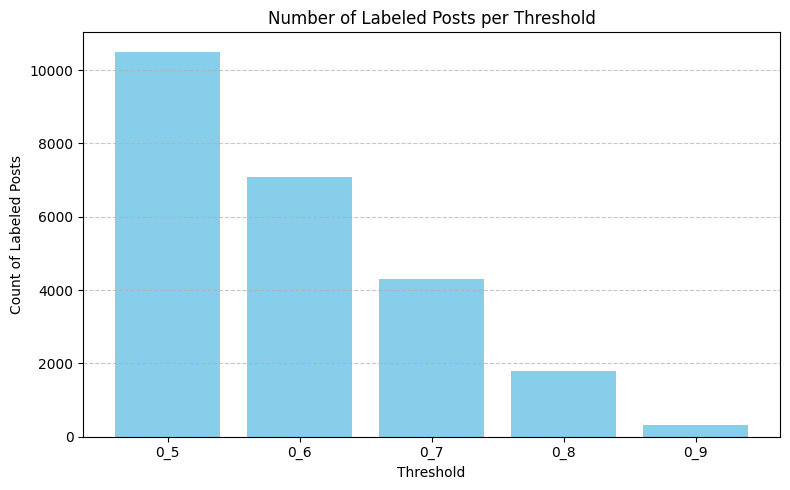

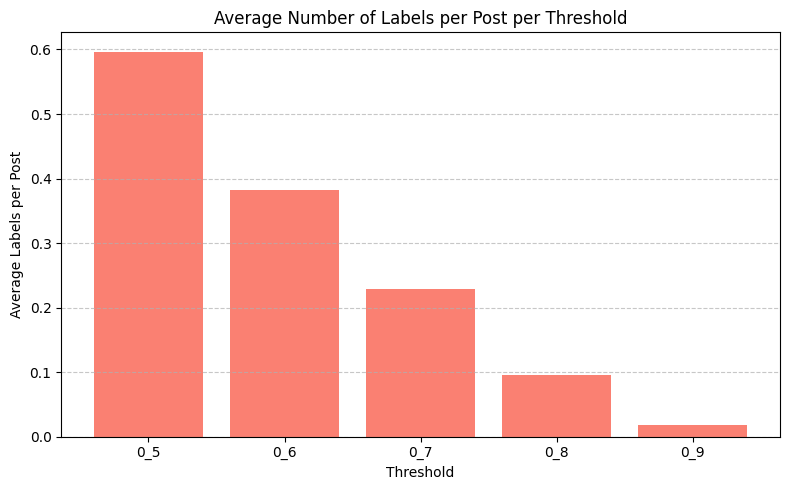

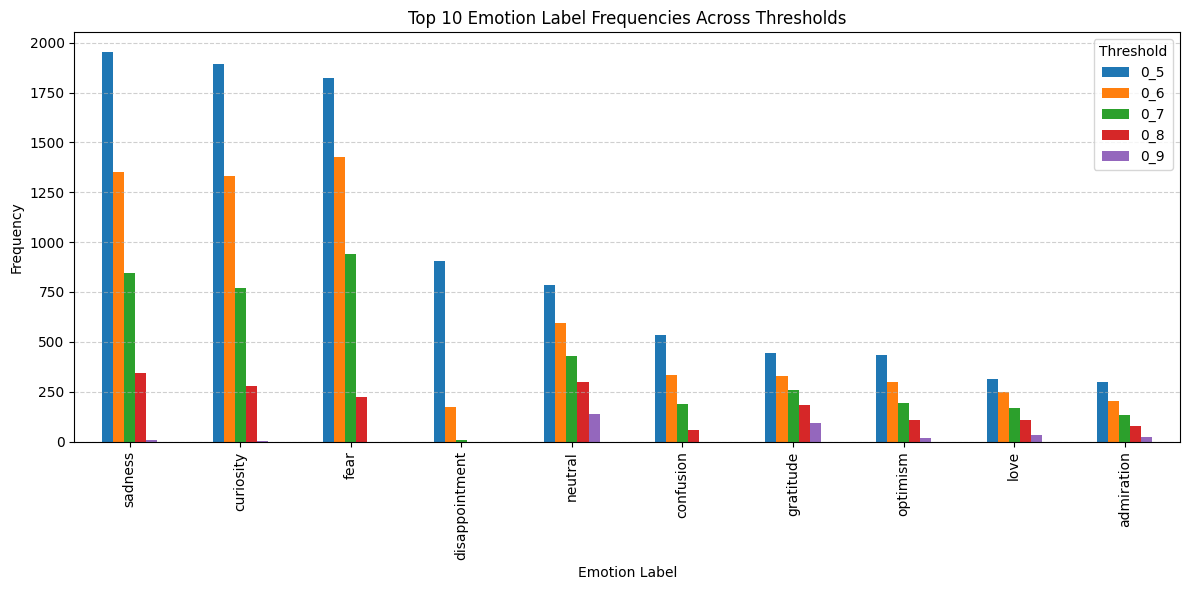

labeled_posts  avg_labels_per_post
threshold                                    
0_5              10506.0             0.596730
0_6               7084.0             0.382022
0_7               4299.0             0.229512
0_8               1804.0             0.096118
0_9                333.0             0.017733

In [ ]:
# EDA on the augmented dataset
import pandas as pd
import matplotlib.pyplot as plt

# Load the augmented dataset
df = pd.read_csv("reddit_goemo28_probs-augmented.csv")

# Identify threshold suffixes
thr_suffixes = ["0_5", "0_6", "0_7", "0_8", "0_9"]

# --- Summary: Number of labeled posts per threshold ---
summary_counts = {}
for s in thr_suffixes:
    num_col = f"num_labels_t{s}"
    if num_col in df.columns:
        labeled_posts = (df[num_col] > 0).sum()
        avg_labels = df[num_col].mean()
        summary_counts[s] = {"labeled_posts": labeled_posts, "avg_labels_per_post": avg_labels}

summary_df = pd.DataFrame(summary_counts).T
summary_df.index.name = "threshold"

# --- Plot 1: Number of labeled posts per threshold ---
plt.figure(figsize=(8, 5))
plt.bar(summary_df.index, summary_df["labeled_posts"], color="skyblue")
plt.title("Number of Labeled Posts per Threshold")
plt.xlabel("Threshold")
plt.ylabel("Count of Labeled Posts")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# --- Plot 2: Average number of labels per post per threshold ---
plt.figure(figsize=(8, 5))
plt.bar(summary_df.index, summary_df["avg_labels_per_post"], color="salmon")
plt.title("Average Number of Labels per Post per Threshold")
plt.xlabel("Threshold")
plt.ylabel("Average Labels per Post")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# --- Label frequency analysis across thresholds ---
import ast
from collections import Counter

label_freqs = {}
for s in thr_suffixes:
    col = f"predicted_emotions_t{s}"
    if col in df.columns:
        # Parse list-like string safely
        all_labels = []
        for x in df[col].dropna():
            try:
                if isinstance(x, str):
                    all_labels.extend(ast.literal_eval(x))
                elif isinstance(x, list):
                    all_labels.extend(x)
            except Exception:
                continue
        label_freqs[s] = Counter(all_labels)

# Convert to DataFrame (labels × thresholds)
label_freq_df = pd.DataFrame(label_freqs).fillna(0).astype(int)
label_freq_df_sorted = label_freq_df.sort_values("0_5", ascending=False)

# --- Plot 3: Top 10 labels frequency comparison across thresholds ---
top_labels = label_freq_df_sorted.head(10)
top_labels.plot(kind="bar", figsize=(12, 6))
plt.title("Top 10 Emotion Label Frequencies Across Thresholds")
plt.xlabel("Emotion Label")
plt.ylabel("Frequency")
plt.legend(title="Threshold")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# Display summary
summary_df


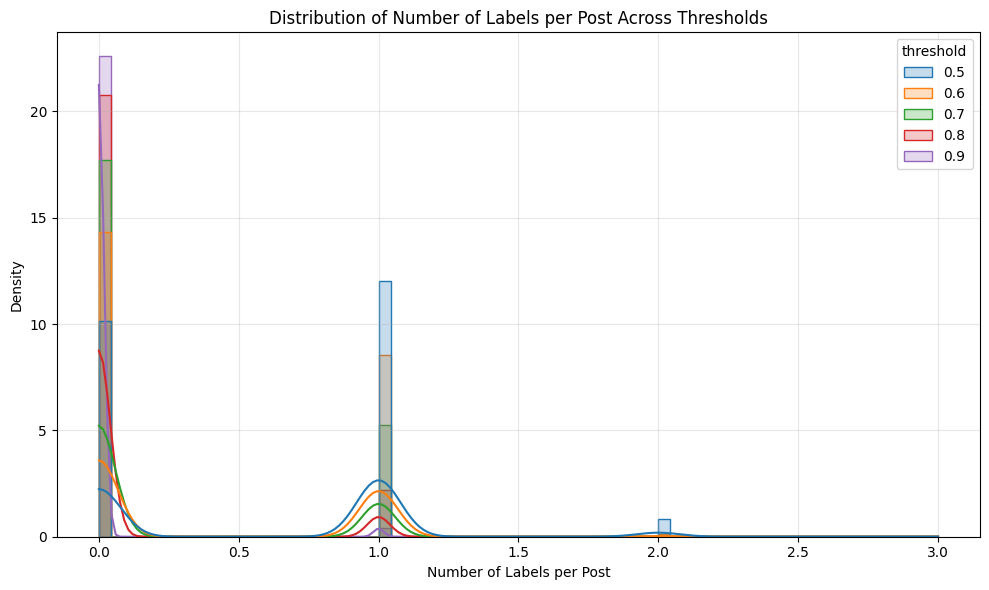

/tmp/ipython-input-3168444128.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=melted, x="threshold", y="num_labels", palette="coolwarm")


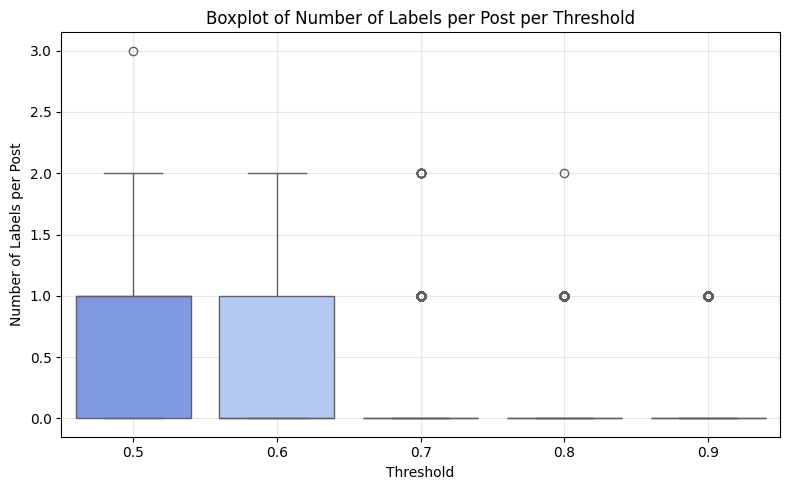

In [ ]:
# Distribution plots for num_labels_t* across thresholds

import seaborn as sns

plt.figure(figsize=(10, 6))

# Prepare melted DataFrame for seaborn
melted = pd.melt(
    df[[f"num_labels_t{s}" for s in ["0_5", "0_6", "0_7", "0_8", "0_9"]]],
    var_name="threshold",
    value_name="num_labels"
)

# Clean up threshold labels
melted["threshold"] = melted["threshold"].str.replace("num_labels_t", "").str.replace("_", ".")

# Plot distribution (density + histogram)
sns.histplot(data=melted, x="num_labels", hue="threshold", kde=True, element="step", stat="density", common_norm=False)
plt.title("Distribution of Number of Labels per Post Across Thresholds")
plt.xlabel("Number of Labels per Post")
plt.ylabel("Density")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Also show boxplot comparison for clearer summary
plt.figure(figsize=(8, 5))
sns.boxplot(data=melted, x="threshold", y="num_labels", palette="coolwarm")
plt.title("Boxplot of Number of Labels per Post per Threshold")
plt.xlabel("Threshold")
plt.ylabel("Number of Labels per Post")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


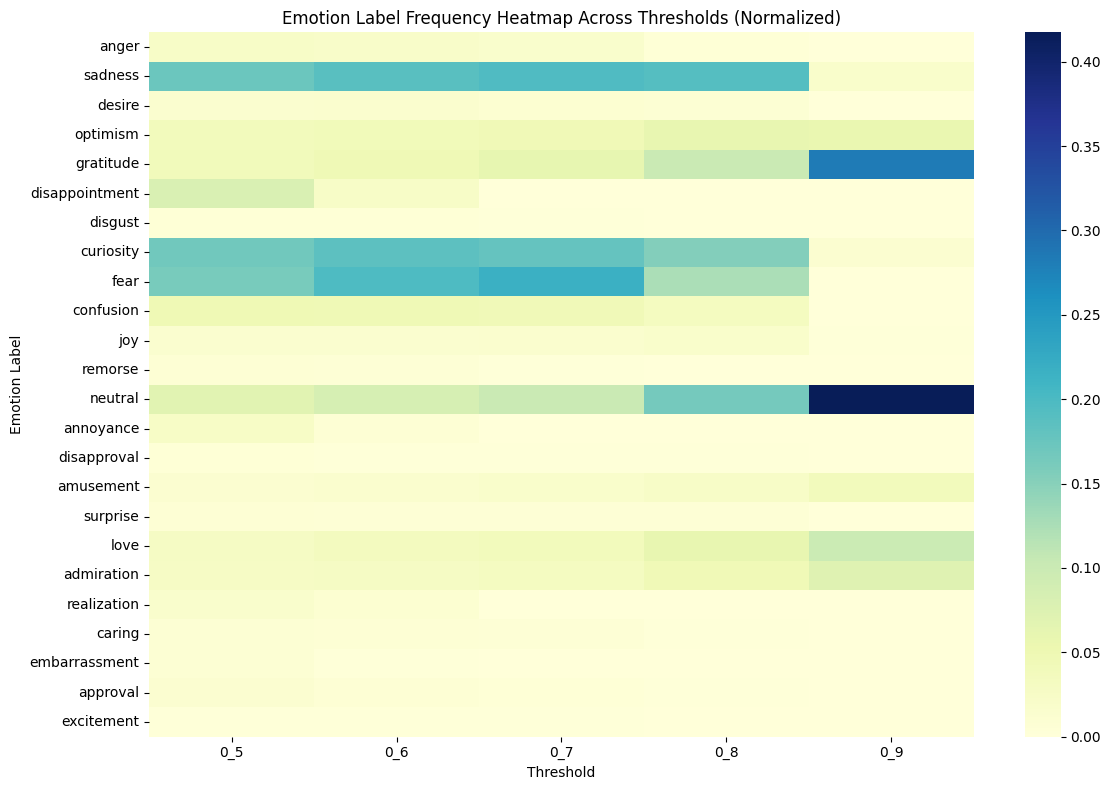

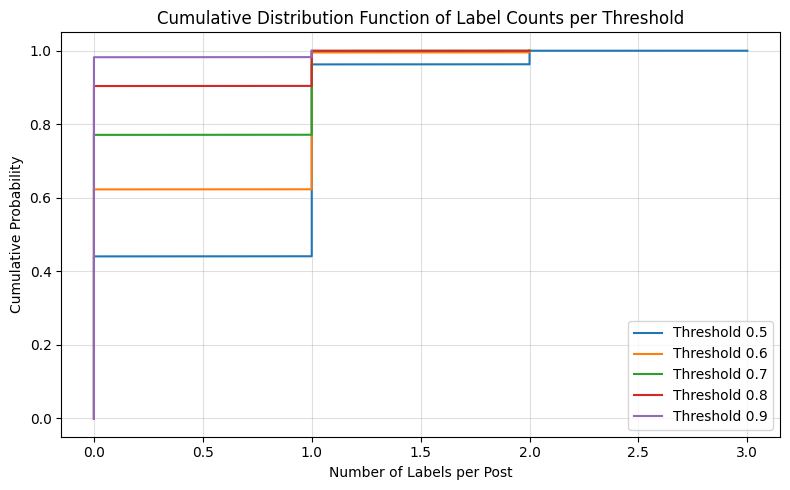

In [ ]:
# Heatmap of label frequency (co-occurrence) across thresholds
import seaborn as sns
import ast

# Compute label frequency per threshold again
from collections import Counter
label_freqs = {}
for s in ["0_5", "0_6", "0_7", "0_8", "0_9"]:
    col = f"predicted_emotions_t{s}"
    if col in df.columns:
        all_labels = []
        for x in df[col].dropna():
            try:
                if isinstance(x, str):
                    all_labels.extend(ast.literal_eval(x))
                elif isinstance(x, list):
                    all_labels.extend(x)
            except Exception:
                continue
        label_freqs[s] = Counter(all_labels)

label_freq_df = pd.DataFrame(label_freqs).fillna(0).astype(int)

# Normalize frequencies to proportions for comparability
label_freq_norm = label_freq_df.div(label_freq_df.sum(axis=0), axis=1)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(label_freq_norm, cmap="YlGnBu", annot=False)
plt.title("Emotion Label Frequency Heatmap Across Thresholds (Normalized)")
plt.xlabel("Threshold")
plt.ylabel("Emotion Label")
plt.tight_layout()
plt.show()

# --- Cumulative Distribution Function (CDF) ---
plt.figure(figsize=(8, 5))
for s in ["0_5", "0_6", "0_7", "0_8", "0_9"]:
    col = f"num_labels_t{s}"
    if col in df.columns:
        sorted_vals = np.sort(df[col].values)
        cdf = np.arange(len(sorted_vals)) / float(len(sorted_vals))
        plt.plot(sorted_vals, cdf, label=f"Threshold {s.replace('_', '.')}")

plt.title("Cumulative Distribution Function of Label Counts per Threshold")
plt.xlabel("Number of Labels per Post")
plt.ylabel("Cumulative Probability")
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Load dataset
df = pd.read_csv("reddit_goemo28_probs-augmented.csv")

# Threshold suffixes
thr_suffixes = ["0_5", "0_6", "0_7", "0_8", "0_9"]

# Compute maximum number of labels for each threshold
for s in thr_suffixes:
    num_col = f"num_labels_t{s}"
    if num_col in df.columns:
        max_labels = df[num_col].max()
        print(f"Threshold {s.replace('_','.')}: max number of labels per post = {int(max_labels)}")


Threshold 0.5: max number of labels per post = 3
Threshold 0.6: max number of labels per post = 2
Threshold 0.7: max number of labels per post = 2
Threshold 0.8: max number of labels per post = 2
Threshold 0.9: max number of labels per post = 1


In [ ]:
import pandas as pd

# Load dataset
df = pd.read_csv("reddit_goemo28_probs-augmented.csv")

# Threshold suffixes
thr_suffixes = ["0_5", "0_6", "0_7", "0_8", "0_9"]

# Compute and display stats
for s in thr_suffixes:
    num_col = f"num_labels_t{s}"
    if num_col in df.columns:
        max_labels = df[num_col].max()
        count_max = (df[num_col] == max_labels).sum()
        print(f"Threshold {s.replace('_','.')}: max labels = {int(max_labels)}, posts with max labels = {count_max}")


Threshold 0.5: max labels = 3, posts with max labels = 1
Threshold 0.6: max labels = 2, posts with max labels = 90
Threshold 0.7: max labels = 2, posts with max labels = 11
Threshold 0.8: max labels = 2, posts with max labels = 1
Threshold 0.9: max labels = 1, posts with max labels = 333


# Insights from Labelled Posts

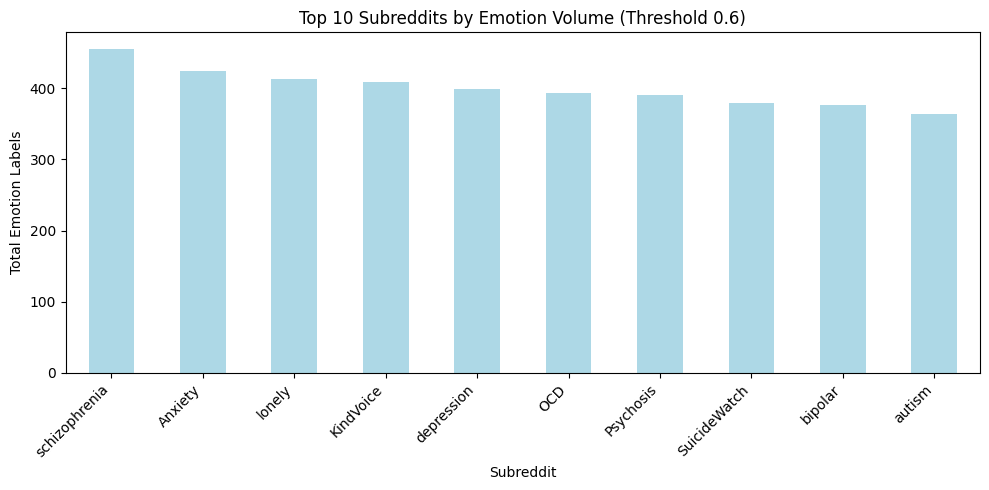

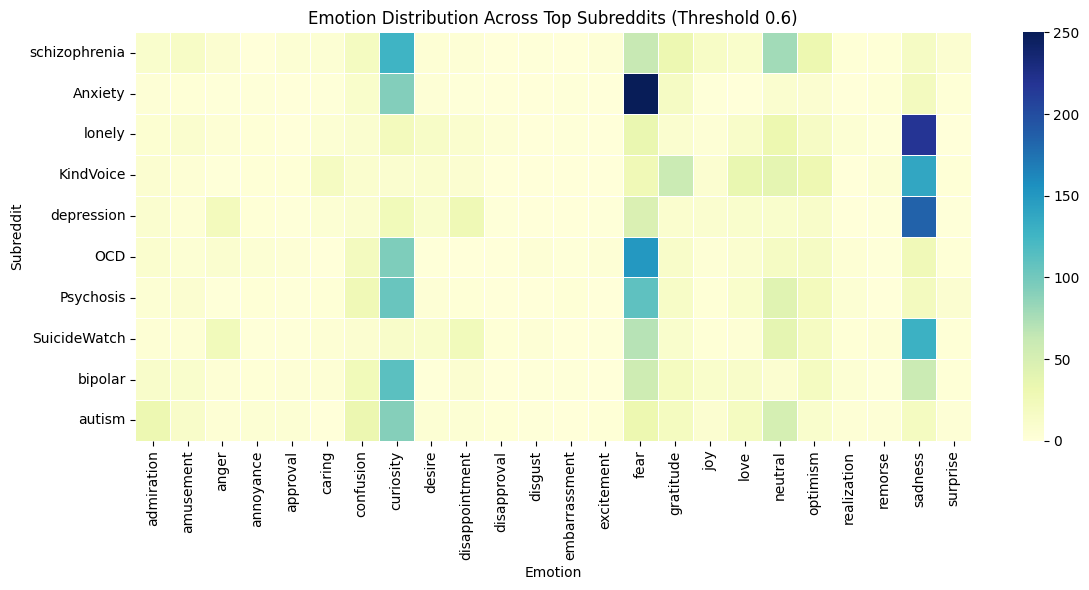

In [ ]:
# =========================================
# Subreddit × Emotion Analysis (Threshold 0.6)
# =========================================
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Load dataset
df = pd.read_csv("reddit_goemo28_probs-augmented.csv")

# Choose threshold to analyze
THRESHOLD = "0_6"
col_labels = f"predicted_emotions_t{THRESHOLD}"

# Parse list-like strings
def parse_list(x):
    if isinstance(x, list):
        return x
    if pd.isna(x):
        return []
    try:
        return ast.literal_eval(str(x))
    except Exception:
        return [s.strip() for s in str(x).split(",") if s.strip()]

df[col_labels] = df[col_labels].apply(parse_list)

# Ensure subreddit column exists
subreddit_col = None
for c in df.columns:
    if "subreddit" in c.lower():
        subreddit_col = c
        break

if subreddit_col is None:
    raise ValueError("No 'subreddit' column found in dataset!")

# Build subreddit → emotion frequency mapping
records = []
for _, row in df.iterrows():
    sub = row[subreddit_col]
    for emo in row[col_labels]:
        records.append((sub, emo))

subemo_df = pd.DataFrame(records, columns=["subreddit", "emotion"])

# Aggregate counts
agg = subemo_df.groupby(["subreddit", "emotion"]).size().reset_index(name="count")

# Pivot for heatmap
pivot = agg.pivot(index="subreddit", columns="emotion", values="count").fillna(0)

# Identify top subreddits by total emotion count
top_subs = pivot.sum(axis=1).sort_values(ascending=False).head(10).index
pivot_top = pivot.loc[top_subs]

# --- Plot 1: Total Emotion Counts per Subreddit ---
plt.figure(figsize=(10, 5))
pivot.sum(axis=1).sort_values(ascending=False).head(10).plot(kind="bar", color="lightblue")
plt.title(f"Top 10 Subreddits by Emotion Volume (Threshold {THRESHOLD.replace('_','.')})")
plt.xlabel("Subreddit")
plt.ylabel("Total Emotion Labels")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# --- Plot 2: Heatmap of Emotion Distribution per Subreddit ---
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_top, cmap="YlGnBu", linewidths=0.5)
plt.title(f"Emotion Distribution Across Top Subreddits (Threshold {THRESHOLD.replace('_','.')})")
plt.xlabel("Emotion")
plt.ylabel("Subreddit")
plt.tight_layout()
plt.show()



Top subreddits by TOP emotion volume (threshold 0.6):
             subreddit    emotion  count  total_count  top_emotion_prop
0              Anxiety       fear    250          424          0.589623
1               lonely    sadness    218          413          0.527845
2           depression    sadness    185          399          0.463659
3                  OCD       fear    150          394          0.380711
4                 ADHD  curiosity    144          349          0.412607
5        socialanxiety       fear    140          342          0.409357
6            KindVoice    sadness    138          409          0.337408
7         SuicideWatch    sadness    129          379          0.340369
8        schizophrenia  curiosity    126          456          0.276316
9              bipolar  curiosity    112          376          0.297872
10           Psychosis       fear    110          391          0.281330
11              autism  curiosity     91          364          0.250000
12       

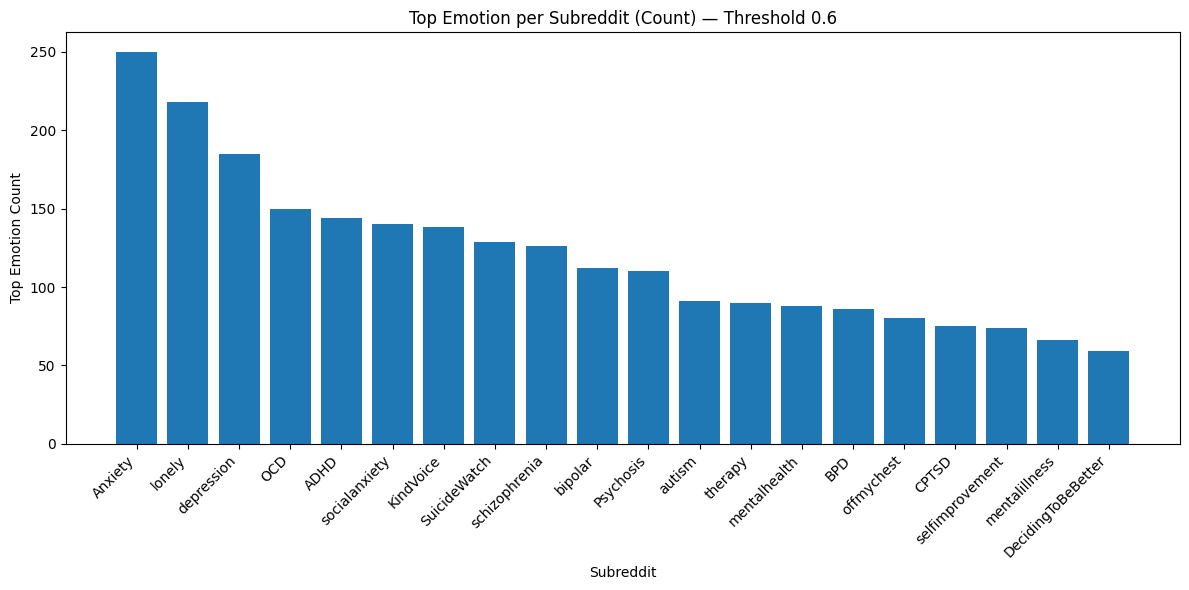

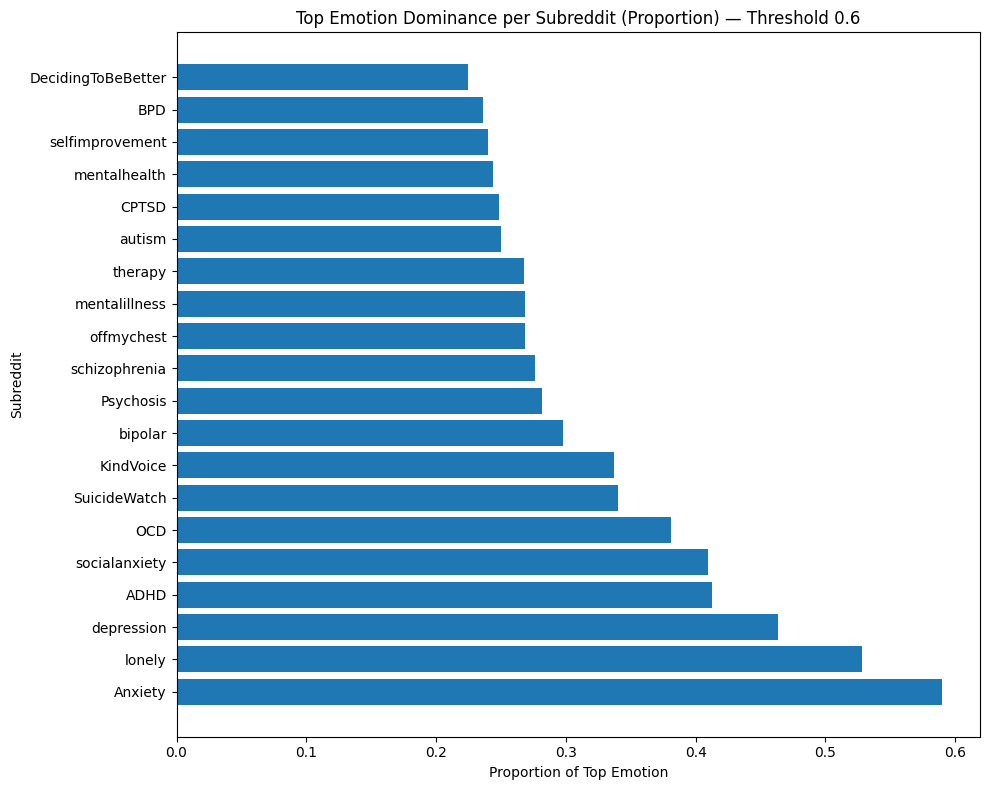

In [ ]:
import pandas as pd
import ast
import matplotlib.pyplot as plt

# --- Config ---
CSV_PATH = "reddit_goemo28_probs-augmented.csv"
THRESHOLD = "0_6"                 # use "0_6" for threshold 0.6
TOP_N_SUBREDDITS = 20             # how many subreddits to display in plots/tables

# --- Load ---
df = pd.read_csv(CSV_PATH)

# --- Find subreddit column (case-insensitive contains 'subreddit') ---
subreddit_col = None
for c in df.columns:
    if "subreddit" in c.lower():
        subreddit_col = c
        break
if subreddit_col is None:
    raise ValueError("No subreddit column found. Add a column named like 'subreddit'.")

# --- Parse predicted emotions list for threshold 0.6 ---
col_labels = f"predicted_emotions_t{THRESHOLD}"
if col_labels not in df.columns:
    raise ValueError(f"Column '{col_labels}' not found in the dataset.")

def parse_list(x):
    if isinstance(x, list):
        return x
    if pd.isna(x):
        return []
    s = str(x)
    try:
        return ast.literal_eval(s)
    except Exception:
        return [t.strip() for t in s.split(",") if t.strip()]

df[col_labels] = df[col_labels].apply(parse_list)

# --- Build (subreddit, emotion) long table ---
records = []
for _, row in df.iterrows():
    sub = row[subreddit_col]
    for emo in row[col_labels]:
        records.append((sub, emo))

subemo = pd.DataFrame(records, columns=["subreddit", "emotion"])

# If many posts have no labels at 0.6, subemo could be empty
if subemo.empty:
    raise ValueError("No labeled emotions at threshold 0.6. Check your data.")

# --- Count emotions per subreddit ---
counts = subemo.groupby(["subreddit", "emotion"]).size().reset_index(name="count")

# --- Determine the top emotion per subreddit ---
# For each subreddit, pick the emotion with the maximum count
idx = counts.groupby("subreddit")["count"].idxmax()
top_emotion_per_sub = counts.loc[idx].copy()  # columns: subreddit, emotion, count

# Add total emotion labels per subreddit and proportion of the top emotion
totals = counts.groupby("subreddit")["count"].sum().rename("total_count")
top_emotion_per_sub = top_emotion_per_sub.merge(totals, on="subreddit", how="left")
top_emotion_per_sub["top_emotion_prop"] = top_emotion_per_sub["count"] / top_emotion_per_sub["total_count"]

# --- Sort by dominance or absolute volume (choose one) ---
# Option A: by absolute volume of top emotion
top_sorted_by_count = top_emotion_per_sub.sort_values("count", ascending=False).reset_index(drop=True)

# Option B: by dominance (proportion of top emotion within subreddit)
top_sorted_by_prop = top_emotion_per_sub.sort_values("top_emotion_prop", ascending=False).reset_index(drop=True)

# --- Show top N subreddits (table) ---
print("\nTop subreddits by TOP emotion volume (threshold 0.6):")
print(top_sorted_by_count.head(TOP_N_SUBREDDITS)[["subreddit","emotion","count","total_count","top_emotion_prop"]])

print("\nTop subreddits by TOP emotion dominance (threshold 0.6):")
print(top_sorted_by_prop.head(TOP_N_SUBREDDITS)[["subreddit","emotion","count","total_count","top_emotion_prop"]])

# --- Optional: Bar plot of TOP emotion counts for top-N subreddits (by count) ---
plot_df = top_sorted_by_count.head(TOP_N_SUBREDDITS)
plt.figure(figsize=(12, 6))
plt.bar(plot_df["subreddit"], plot_df["count"])
plt.title("Top Emotion per Subreddit (Count) — Threshold 0.6")
plt.xlabel("Subreddit")
plt.ylabel("Top Emotion Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# --- Optional: Horizontal bar plot of TOP emotion dominance for top-N by dominance ---
plot_df2 = top_sorted_by_prop.head(TOP_N_SUBREDDITS)
plt.figure(figsize=(10, 8))
plt.barh(plot_df2["subreddit"], plot_df2["top_emotion_prop"])
plt.title("Top Emotion Dominance per Subreddit (Proportion) — Threshold 0.6")
plt.xlabel("Proportion of Top Emotion")
plt.ylabel("Subreddit")
plt.tight_layout()
plt.show()



## Circumplex Model of Affect for Labelled Posts

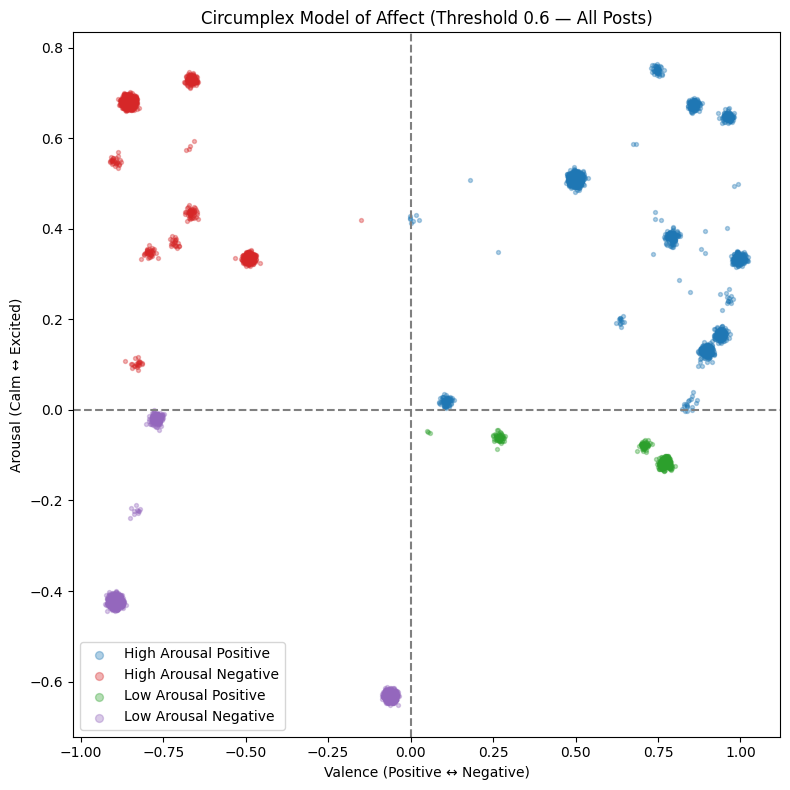

circumplex_quadrant
High Arousal Positive    2509
Low Arousal Negative     2107
High Arousal Negative    2065
Low Arousal Positive      403
Name: count, dtype: int64
✅ Saved augmented file with VAD columns → reddit_goemo28_probs-augmented-with-VAD.csv


In [ ]:
import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt

# =========================
# 1) Load files
# =========================
vad_path = "NRC-VAD-Lexicon-v2.1.txt"
data_path = "reddit_goemo28_probs-augmented.csv"

df  = pd.read_csv(data_path)
vad = pd.read_csv(vad_path, sep="\t", header=0, names=["term", "valence", "arousal", "dominance"])

# =========================
# 2) Parse emotion labels (threshold 0.6)
# =========================
col_labels = "predicted_emotions_t0_6"

def parse_list(x):
    if isinstance(x, list):
        return x
    if pd.isna(x):
        return []
    s = str(x)
    try:
        return ast.literal_eval(s)
    except Exception:
        return [t.strip() for t in s.split(",") if t.strip()]

df[col_labels] = df[col_labels].apply(parse_list)

# =========================
# 3) Compute valence & arousal averages (neutral fallback for missing terms)
# =========================
emo_map = {
    "admiration":"admiration","amusement":"amusement","anger":"anger","annoyance":"annoyance",
    "approval":"approval","caring":"caring","confusion":"confusion","curiosity":"curiosity",
    "desire":"desire","disappointment":"disappointment","disapproval":"disapproval","disgust":"disgust",
    "embarrassment":"embarrassment","excitement":"excitement","fear":"fear","gratitude":"gratitude",
    "grief":"grief","joy":"joy","love":"love","nervousness":"nervousness","optimism":"optimism",
    "pride":"pride","realization":"realization","relief":"relief","remorse":"remorse",
    "sadness":"sadness","surprise":"surprise","neutral":"neutral"
}

vad_emotions = vad[vad["term"].isin(emo_map.values())][["term","valence","arousal"]]
vad_dict = vad_emotions.set_index("term")[["valence","arousal"]].to_dict(orient="index")

# fallback to neutral (0.0, 0.0) if an emotion term isn't found in VAD
for emo in emo_map.values():
    if emo not in vad_dict:
        vad_dict[emo] = {"valence":0.0, "arousal":0.0}

valence_scores, arousal_scores = [], []
for labels in df[col_labels]:
    if not labels:
        valence_scores.append(None)
        arousal_scores.append(None)
        continue
    vals = [vad_dict.get(emo_map[e], {"valence":0.0})["valence"] for e in labels]
    aros = [vad_dict.get(emo_map[e], {"arousal":0.0})["arousal"] for e in labels]
    valence_scores.append(sum(vals)/len(vals))
    arousal_scores.append(sum(aros)/len(aros))

df["valence"] = valence_scores
df["arousal"] = arousal_scores

# =========================
# 4) Quadrants (unchanged strategy)
# =========================
def quadrant(v, a):
    if pd.isna(v) or pd.isna(a):
        return None
    if v >= 0 and a >= 0:
        return "High Arousal Positive"
    if v <  0 and a >= 0:
        return "High Arousal Negative"
    if v <  0 and a <  0:
        return "Low Arousal Negative"
    if v >= 0 and a <  0:
        return "Low Arousal Positive"

df["circumplex_quadrant"] = df.apply(lambda x: quadrant(x["valence"], x["arousal"]), axis=1)

# =========================
# 5) Jitter for plotting ONLY (to reveal overlapping points)
# =========================
rng = np.random.default_rng(42)
v_range = (df["valence"].max() - df["valence"].min()) or 1.0
a_range = (df["arousal"].max() - df["arousal"].min()) or 1.0
v_jit = 0.005 * v_range   # ~0.5% jitter
a_jit = 0.005 * a_range

df["_valence_plot"] = df["valence"] + rng.normal(0.0, v_jit, size=len(df))
df["_arousal_plot"] = df["arousal"] + rng.normal(0.0, a_jit, size=len(df))

# Keep only posts that actually have ≥1 label at t0.6
plot_df = df[df[col_labels].map(len) > 0].copy()

# =========================
# 6) Visualization (all posts with t0.6 labels)
# =========================
plt.figure(figsize=(8, 8))
colors = {
    "High Arousal Positive": "#1f77b4",
    "High Arousal Negative": "#d62728",
    "Low Arousal Positive": "#2ca02c",
    "Low Arousal Negative": "#9467bd"
}

for quad, color in colors.items():
    sub = plot_df[plot_df["circumplex_quadrant"] == quad]
    plt.scatter(sub["_valence_plot"], sub["_arousal_plot"], label=quad, alpha=0.35, s=8, c=color)

plt.axhline(0, color="gray", linestyle="--")
plt.axvline(0, color="gray", linestyle="--")
plt.title("Circumplex Model of Affect (Threshold 0.6 — All Posts)")
plt.xlabel("Valence (Positive ↔ Negative)")
plt.ylabel("Arousal (Calm ↔ Excited)")
plt.legend(markerscale=2)
plt.tight_layout()
plt.show()

# =========================
# 7) Save outputs
# =========================
print(plot_df["circumplex_quadrant"].value_counts(dropna=True))

# Save base visualization data
plot_df.to_csv("reddit_with_vad_circumplex_t0_6_all.csv", index=False)

# =========================
# 8) NEW: Add valence/arousal/quadrant to reddit_goemo28_probs-augmented.csv
# =========================
output_path = "reddit_goemo28_probs-augmented-with-VAD.csv"

try:
    base_df = pd.read_csv(data_path)
    merged_df = base_df.reset_index(drop=True).join(
        df[["valence", "arousal", "circumplex_quadrant"]].reset_index(drop=True)
    )
    merged_df.to_csv(output_path, index=False)
    print(f"✅ Saved augmented file with VAD columns → {output_path}")
except FileNotFoundError:
    print(f"⚠️ Base file '{data_path}' not found. Saving fallback output.")
    df.to_csv(output_path, index=False)


## Insights from High Arousal Negative Valence Posts

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Load dataset
df = pd.read_csv("reddit_goemo28_probs-augmented-with-VAD.csv")

# Filter for High Arousal Negative quadrant
han = df[df["circumplex_quadrant"] == "High Arousal Negative"].copy()
print(f"High Arousal Negative posts: {len(han)}")

# Clean text
han["selftext"] = han["selftext"].astype(str).fillna("").str.strip()
han = han[han["selftext"] != ""]


High Arousal Negative posts: 2065


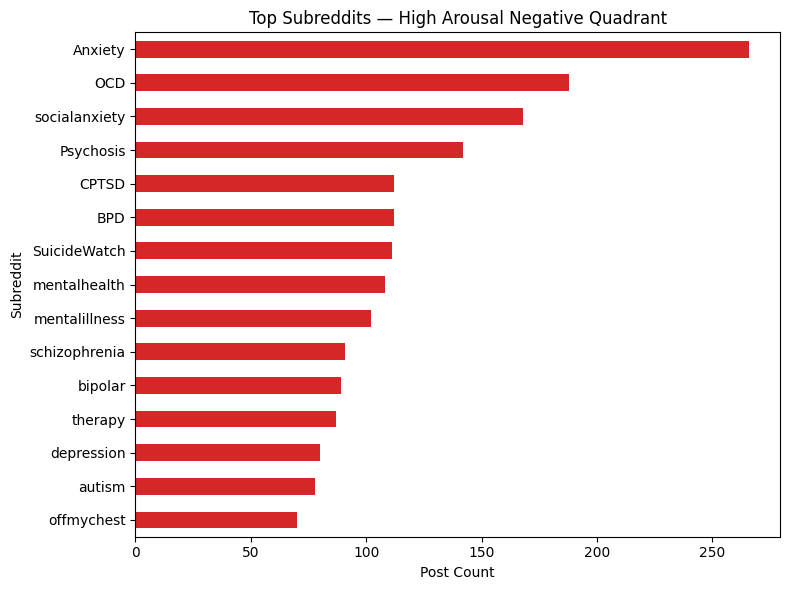

In [ ]:
plt.figure(figsize=(8,6))
han["subreddit"].value_counts().head(15).sort_values().plot(kind="barh", color="#d62728")
plt.title("Top Subreddits — High Arousal Negative Quadrant")
plt.xlabel("Post Count")
plt.ylabel("Subreddit")
plt.tight_layout()
plt.show()


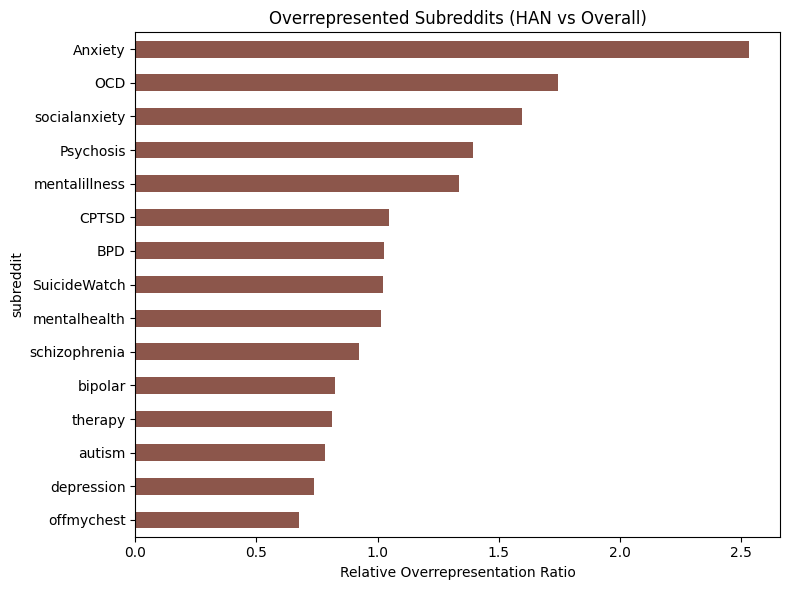

In [ ]:
han_share = han["subreddit"].value_counts(normalize=True)
all_share = df["subreddit"].value_counts(normalize=True)
overrep = (han_share / all_share).dropna().sort_values(ascending=False).head(15)

plt.figure(figsize=(8,6))
overrep.sort_values().plot(kind="barh", color="#8c564b")
plt.title("Overrepresented Subreddits (HAN vs Overall)")
plt.xlabel("Relative Overrepresentation Ratio")
plt.tight_layout()
plt.show()


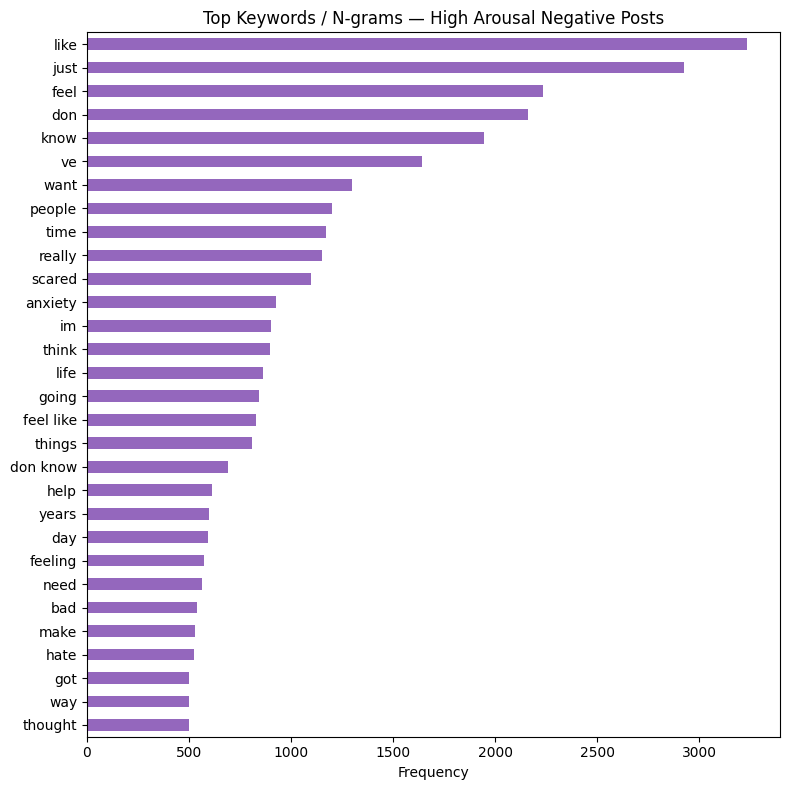

In [ ]:
def clean_text(s):
    s = s.lower()
    s = re.sub(r"http\S+|www\.\S+", " ", s)
    s = re.sub(r"[\d_]+", " ", s)
    return s

texts = han["selftext"].map(clean_text).tolist()

cv = CountVectorizer(stop_words="english", ngram_range=(1,2), min_df=5, max_features=40_000)
X = cv.fit_transform(texts)
freq = pd.Series(X.sum(axis=0).A1, index=cv.get_feature_names_out()).sort_values(ascending=False).head(30)

plt.figure(figsize=(8,8))
freq.sort_values().plot(kind="barh", color="#9467bd")
plt.title("Top Keywords / N-grams — High Arousal Negative Posts")
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()


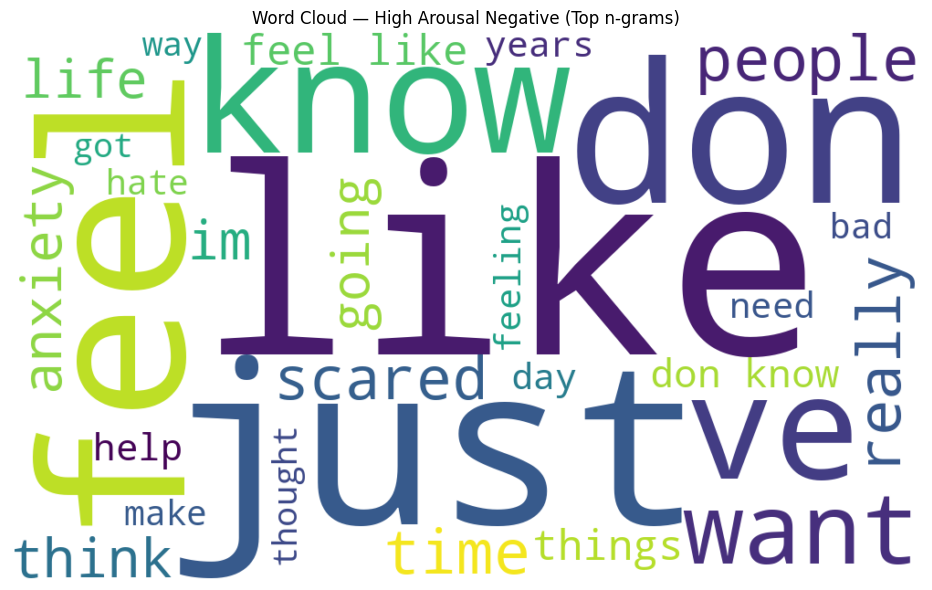

In [ ]:
# If not installed:
# !pip install wordcloud

from wordcloud import WordCloud

# Use the frequency Series from Cell 4: `freq`
freq_dict = freq.to_dict()

wc = WordCloud(
    width=1000, height=600,
    background_color="white",
    collocations=False
).generate_from_frequencies(freq_dict)

plt.figure(figsize=(10,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud — High Arousal Negative (Top n-grams)")
plt.tight_layout()
plt.show()


# Network Modelling to uncover bridge emotions

Data shape: 20 samples × 28 emotions
✅ Using GraphicalLassoCV (cross-validated)...


/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:185: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



🔗 Top Bridge Emotions:
           Emotion  Betweenness    Degree
15          desire     0.816239  0.222222
18       confusion     0.789174  0.111111
20             joy     0.754986  0.148148
2             fear     0.652422  0.185185
9      disapproval     0.612536  0.148148
4       excitement     0.608262  0.148148
23        surprise     0.592593  0.222222
12           grief     0.586895  0.222222
8   disappointment     0.507123  0.185185
19       curiosity     0.488604  0.185185


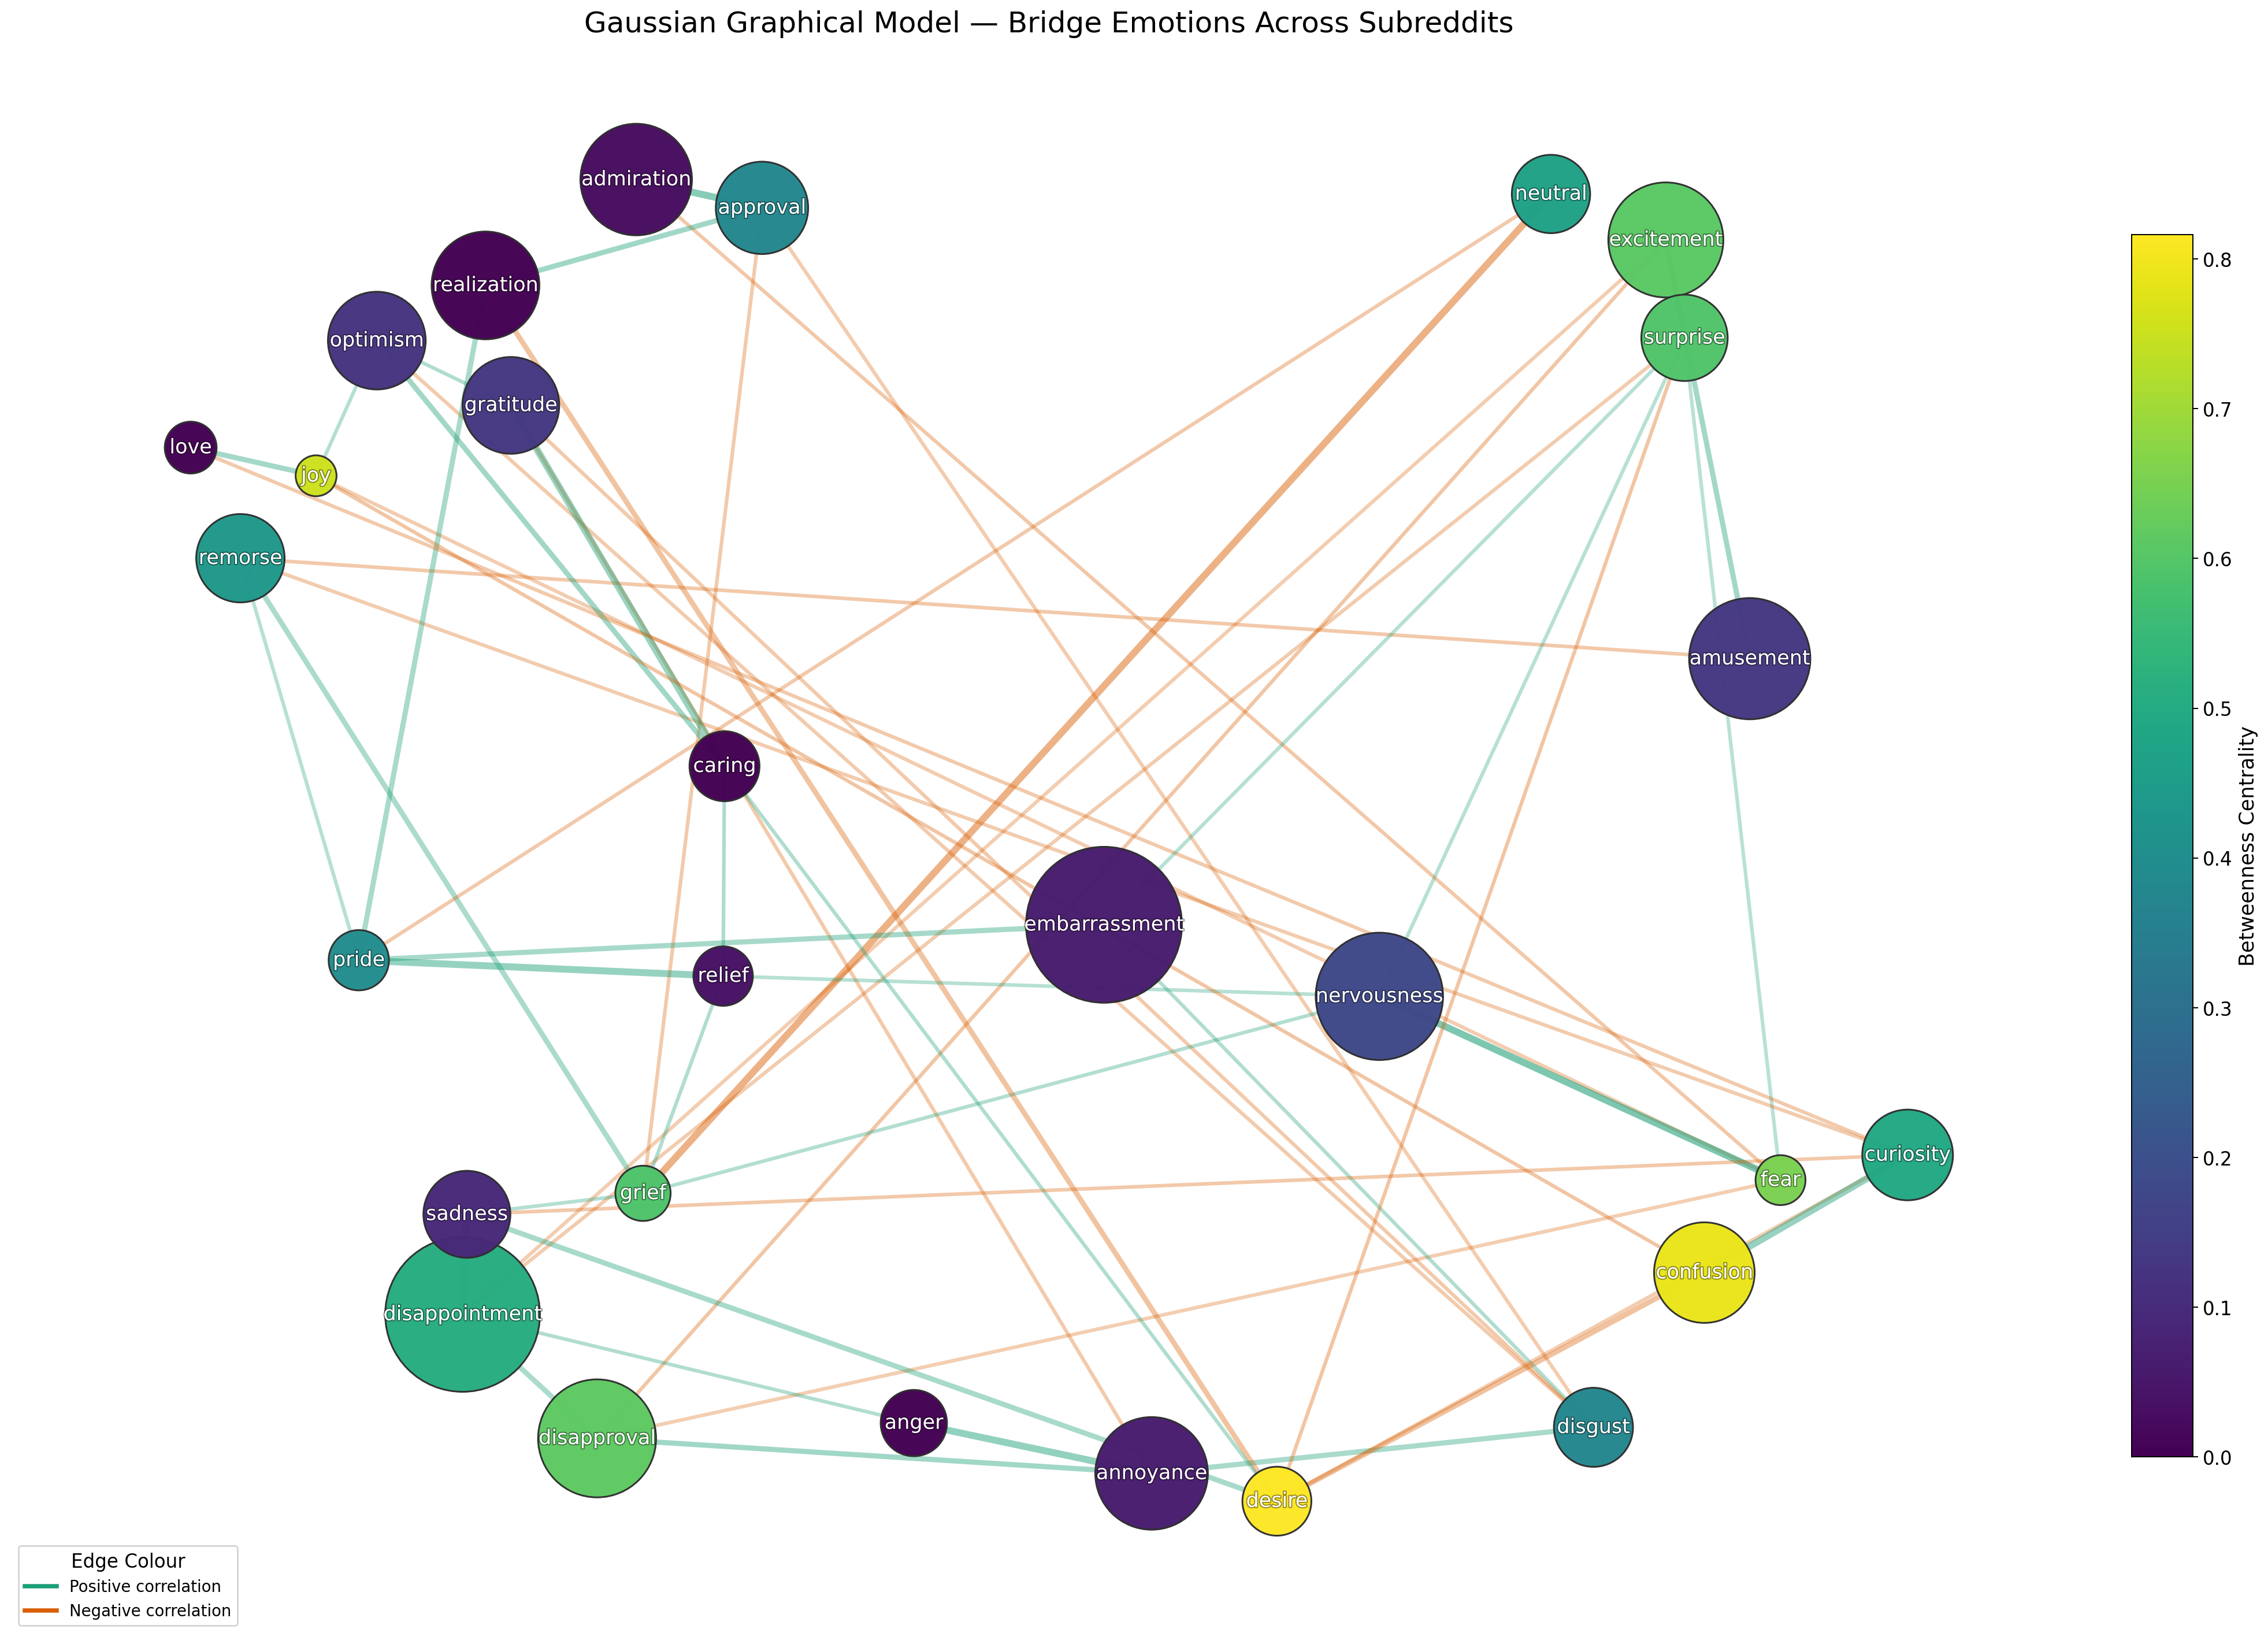

In [ ]:
# ======================================================
# Gaussian Graphical Model — Clean Presentation Plot
# Full 28 labels • Per-edge alpha • No table overlay
# ======================================================

import math
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects
import networkx as nx
from sklearn.covariance import GraphicalLassoCV, GraphicalLasso
from matplotlib.lines import Line2D

# -----------------------------
# Global styling
# -----------------------------
mpl.rcParams.update({
    "figure.dpi": 180,
    "savefig.dpi": 300,
    "font.size": 13,
    "axes.titlesize": 20,
    "legend.fontsize": 11
})

# -----------------------------
# 1) Load & Prepare Data
# -----------------------------
df = pd.read_csv("/content/reddit_goemo28_probs-augmented-with-VAD.csv")
emo_cols = [c for c in df.columns if c.startswith("p_")]

X = df.groupby("subreddit")[emo_cols].mean()
X = (X - X.mean()) / X.std()
X = X.replace([np.inf, -np.inf], np.nan).fillna(0.0)
n_samples, n_features = X.shape
print(f"Data shape: {n_samples} samples × {n_features} emotions")

# -----------------------------
# 2) Fit Graphical Lasso (GGM)
# -----------------------------
if n_samples >= 5:
    print("✅ Using GraphicalLassoCV (cross-validated)...")
    model = GraphicalLassoCV(cv=min(5, n_samples))
else:
    print("⚠️ Too few samples — using GraphicalLasso(alpha=0.05)")
    model = GraphicalLasso(alpha=0.05)
model.fit(X)

precision = model.precision_
partial_corr = -precision / np.sqrt(np.outer(np.diag(precision), np.diag(precision)))
np.fill_diagonal(partial_corr, 0.0)
partial_corr = np.nan_to_num(partial_corr, nan=0.0)

# -----------------------------
# 3) Build Network (|ρ| > 0.10)
# -----------------------------
G = nx.Graph()
for i, ei in enumerate(emo_cols):
    for j in range(i+1, len(emo_cols)):
        ej = emo_cols[j]
        w = partial_corr[i, j]
        if abs(w) > 0.10:
            G.add_edge(ei.replace("p_", ""), ej.replace("p_", ""), weight=w)

btw = nx.betweenness_centrality(G, weight="weight")
deg = nx.degree_centrality(G)

print("\n🔗 Top Bridge Emotions:")
print(pd.DataFrame({
    "Emotion": list(btw.keys()),
    "Betweenness": list(btw.values()),
    "Degree": list(deg.values())
}).sort_values("Betweenness", ascending=False).head(10))

# -----------------------------
# 4) Layout & Node Sizing Helpers
# -----------------------------
def choose_layout(G, seed=42):
    try:
        from networkx.drawing.nx_agraph import graphviz_layout
        return graphviz_layout(G, prog="sfdp")
    except:
        try:
            return nx.kamada_kawai_layout(G, weight="weight")
        except:
            return nx.spring_layout(G, k=1.1, iterations=500, seed=seed, weight="weight")

def repel_positions(pos, min_dist=0.14, iters=200, step=0.012):
    nodes = list(pos.keys())
    for _ in range(iters):
        moved = False
        for i in range(len(nodes)):
            for j in range(i+1, len(nodes)):
                u, v = nodes[i], nodes[j]
                dx = pos[v][0] - pos[u][0]
                dy = pos[v][1] - pos[u][1]
                dist = (dx*dx + dy*dy)**0.5 + 1e-9
                if dist < min_dist:
                    push = (min_dist - dist) * step
                    ux, uy = dx/dist, dy/dist
                    pos[u][0] -= ux * push; pos[u][1] -= uy * push
                    pos[v][0] += ux * push; pos[v][1] += uy * push
                    moved = True
        if not moved:
            break
    return pos

def compute_node_sizes_for_labels(G, labels, ax, font_size=14, pad_px=14):
    fig = ax.figure
    renderer = fig.canvas.get_renderer()
    sizes = {}
    for n, label in labels.items():
        t = ax.text(0, 0, label, fontsize=font_size)
        bb = t.get_window_extent(renderer=renderer); t.remove()
        w_px = bb.width + 2*pad_px
        h_px = bb.height + 2*pad_px
        diam_px = max(w_px, h_px)
        dpi = fig.dpi
        diam_pt = diam_px * 72 / dpi
        sizes[n] = math.pi * (diam_pt/2)**2
    return sizes

# -----------------------------
# 5) Layout
# -----------------------------
pos = choose_layout(G, seed=42)
pos = repel_positions({n: np.array(p, float) for n,p in pos.items()})

labels = {n: n for n in G.nodes()}

fig, ax = plt.subplots(figsize=(22, 16), facecolor="white")
_ = nx.draw_networkx_labels(G, pos, labels, font_size=14, alpha=0.0, ax=ax)
ax.cla()

node_sizes = compute_node_sizes_for_labels(G, labels, ax, font_size=14, pad_px=14)
node_sizes = [node_sizes[n] for n in G.nodes()]

# Node colours (betweenness)
bet_vals = np.array([btw[n] for n in G.nodes()])
norm_nodes = mpl.colors.Normalize(vmin=bet_vals.min(), vmax=bet_vals.max())
node_cmap = plt.cm.viridis

# Edge properties
edge_abs = np.array([abs(G[u][v]['weight']) for u,v in G.edges()])
edge_sign = np.array([np.sign(G[u][v]['weight']) for u,v in G.edges()])

def bin_width(w):
    return 4.8 if w >= 0.30 else (3.6 if w >= 0.20 else 2.5)

edge_widths = [bin_width(w) for w in edge_abs]
edge_alphas = [0.25 + 0.55*w for w in edge_abs]
pos_color, neg_color = "#1b9e77", "#d95f02"
edge_colors = [pos_color if s >= 0 else neg_color for s in edge_sign]

# -----------------------------
# 6) Draw Graph
# -----------------------------
for i, (u, v) in enumerate(G.edges()):
    nx.draw_networkx_edges(G, pos,
        edgelist=[(u,v)],
        width=[edge_widths[i]],
        edge_color=[edge_colors[i]],
        alpha=edge_alphas[i],
        ax=ax)

nx.draw_networkx_nodes(G, pos,
    node_size=node_sizes,
    node_color=[node_cmap(norm_nodes(btw[n])) for n in G.nodes()],
    linewidths=1.2, edgecolors="#2f2f2f", alpha=0.98, ax=ax)

nx.draw_networkx_labels(G, pos, labels, font_size=14, font_color="white", ax=ax)
for artist in ax.texts:
    artist.set_path_effects([patheffects.Stroke(linewidth=1.5, foreground='black', alpha=0.4),
                             patheffects.Normal()])

# -----------------------------
# 7) Legend + Colorbar
# -----------------------------
sm = mpl.cm.ScalarMappable(cmap=node_cmap, norm=norm_nodes)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, fraction=0.028, pad=0.02)
cbar.set_label("Betweenness Centrality", fontsize=14)

ax.legend(handles=[
    Line2D([0],[0], color=pos_color, lw=3, label="Positive correlation"),
    Line2D([0],[0], color=neg_color, lw=3, label="Negative correlation")
], loc="lower left", frameon=True, framealpha=0.92, title="Edge Colour")

ax.set_title("Gaussian Graphical Model — Bridge Emotions Across Subreddits", pad=18)
ax.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
edges_list = []
for u, v, d in G.edges(data=True):
    edges_list.append((u, v, d['weight'], abs(d['weight']), "Positive" if d['weight']>=0 else "Negative"))

edges_df = pd.DataFrame(edges_list, columns=["Emotion A","Emotion B","rho","|rho|","Sign"])
edges_df = edges_df.sort_values("|rho|", ascending=False)

print("\n📊 Top Correlation Edges:")
print(edges_df.head(12))

# Optional: save
# edges_df.to_csv("partial_corr_summary.csv", index=False)



📊 Top Correlation Edges:
         Emotion A    Emotion B       rho     |rho|      Sign
7             fear  nervousness  0.581296  0.581296  Positive
0       admiration     approval  0.501546  0.501546  Positive
33           grief      neutral -0.412564  0.412564  Negative
17           anger    annoyance  0.403791  0.403791  Positive
23  disappointment      sadness  0.398116  0.398116  Positive
45          relief        pride  0.376632  0.376632  Positive
46       confusion    curiosity  0.375096  0.375096  Positive
28       gratitude       caring  0.350231  0.350231  Positive
19       annoyance  disapproval  0.296467  0.296467  Positive
4         approval  realization  0.294376  0.294376  Positive
37          caring     optimism  0.288858  0.288858  Positive
9        amusement   excitement  0.279201  0.279201  Positive


# Insights from unlabled posts

In [ ]:
import pandas as pd

# 1️⃣ Load dataset
df = pd.read_csv("reddit_goemo28_probs-augmented-with-VAD.csv", low_memory=False)
print("Columns:", list(df.columns)[:15])  # sanity check

# 2️⃣ Filter unlabeled posts using num_labels_t0_6 == 0
if "num_labels_t0_6" not in df.columns:
    raise ValueError("⚠️ 'num_labels_t0_6' column not found in dataset!")

df_unlab = df[df["num_labels_t0_6"] == 0].copy()
print("✅ Unlabeled posts (num_labels_t0_6 == 0):", len(df_unlab))

# 3️⃣ Use your pre-cleaned text column
clean_col = "processed_selftext"
assert clean_col in df_unlab.columns, f"'{clean_col}' not found in dataset!"

docs = df_unlab[clean_col].fillna("").astype(str).tolist()
print("Sample text:", docs[0][:200])



Columns: ['id', 'title', 'selftext', 'created_utc', 'num_comments', 'score', 'subreddit', 'author', 'url', 'comments', 'processed_title', 'processed_selftext', 'processed_comments', 'p_admiration', 'p_amusement']
✅ Unlabeled posts (num_labels_t0_6 == 0): 11695
Sample text: think something wrong know explain feel words last months ive felt disconnected detached everything like living really connected attached situations happen emotional sense like really feeling anything


## LDA on unlabelled posts

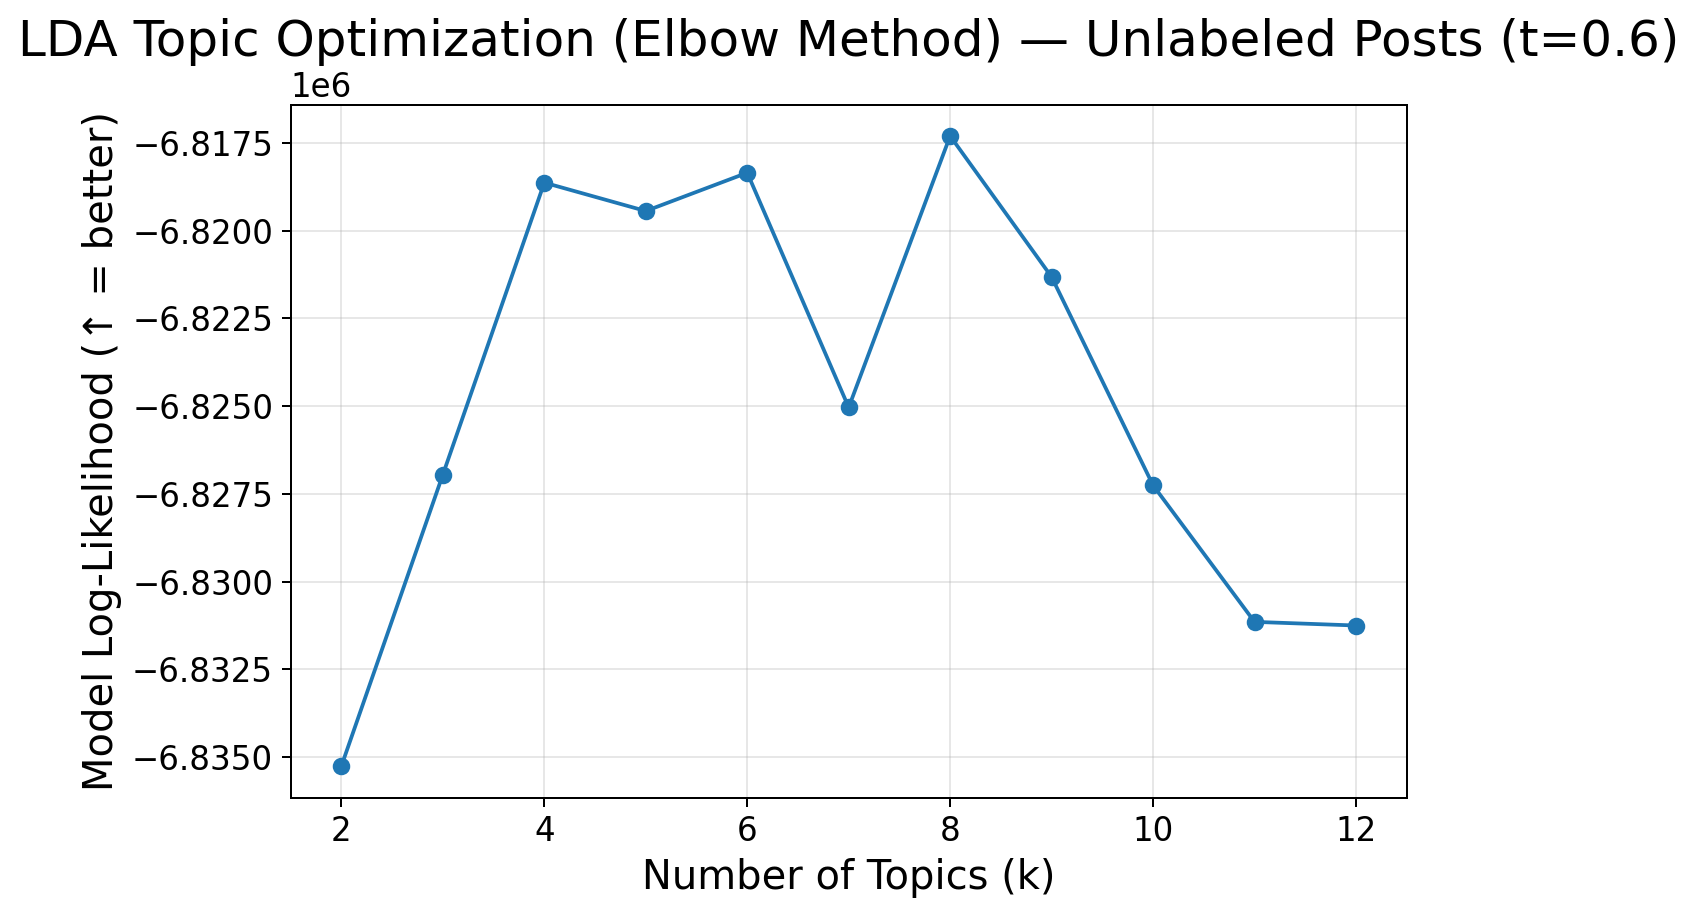

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import numpy as np

# Vectorize using bag-of-words
vectorizer = CountVectorizer(max_df=0.9, min_df=10, stop_words="english")
X = vectorizer.fit_transform(docs)

# Range of topics to try
k_values = range(2, 13)
log_likelihoods = []

for k in k_values:
    lda = LatentDirichletAllocation(n_components=k, random_state=42, max_iter=15)
    lda.fit(X)
    log_likelihoods.append(lda.score(X))

plt.figure(figsize=(8,5))
plt.plot(k_values, log_likelihoods, marker="o")
plt.title("LDA Topic Optimization (Elbow Method) — Unlabeled Posts (t=0.6)")
plt.xlabel("Number of Topics (k)")
plt.ylabel("Model Log-Likelihood (↑ = better)")
plt.grid(alpha=0.3)
plt.show()


In [ ]:
optimal_k = 7  # 👈 update based on elbow plot
lda_final = LatentDirichletAllocation(n_components=optimal_k, random_state=42, max_iter=30)
lda_final.fit(X)

terms = np.array(vectorizer.get_feature_names_out())

for i, topic in enumerate(lda_final.components_):
    top_words = terms[np.argsort(topic)[-10:][::-1]]
    print(f"🧩 Topic {i+1}: {', '.join(top_words)}")

# Assign dominant topic per post
topic_probs = lda_final.transform(X)
df_unlab["dominant_topic"] = topic_probs.argmax(axis=1)
df_unlab["topic_confidence"] = topic_probs.max(axis=1)


🧩 Topic 1: like, thoughts, know, psychosis, ocd, bipolar, episode, feel, ive, think
🧩 Topic 2: like, dont, want, day, time, work, life, money, job, need
🧩 Topic 3: like, feel, people, things, really, know, therapy, think, lot, help
🧩 Topic 4: anxiety, work, time, years, feel, really, job, day, help, got
🧩 Topic 5: like, said, mom, told, time, got, felt, started, know, things
🧩 Topic 6: feel, like, life, want, know, love, time, people, years, feels
🧩 Topic 7: like, dont, know, people, feel, want, friends, really, ive, think


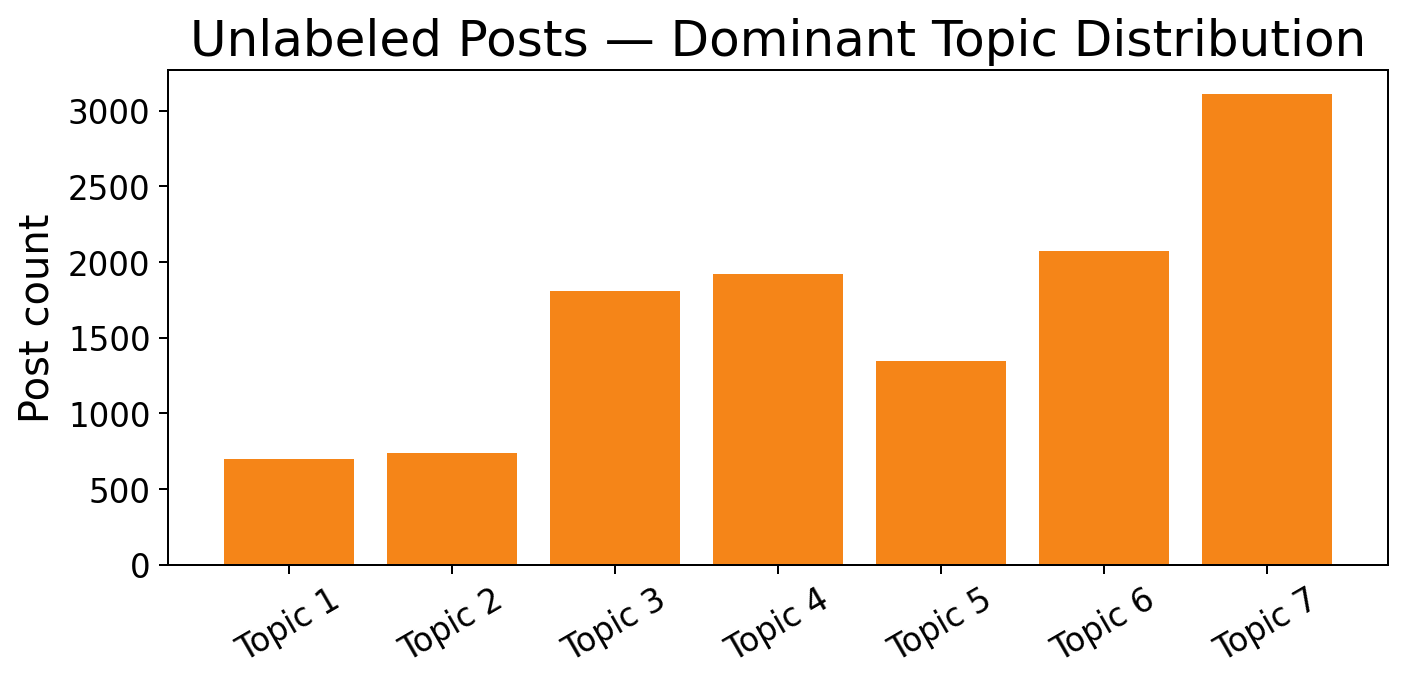

In [ ]:
topic_counts = df_unlab["dominant_topic"].value_counts().sort_index()
plt.figure(figsize=(8,4))
plt.bar([f"Topic {i+1}" for i in topic_counts.index], topic_counts.values, color="#F58518")
plt.ylabel("Post count")
plt.title("Unlabeled Posts — Dominant Topic Distribution")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


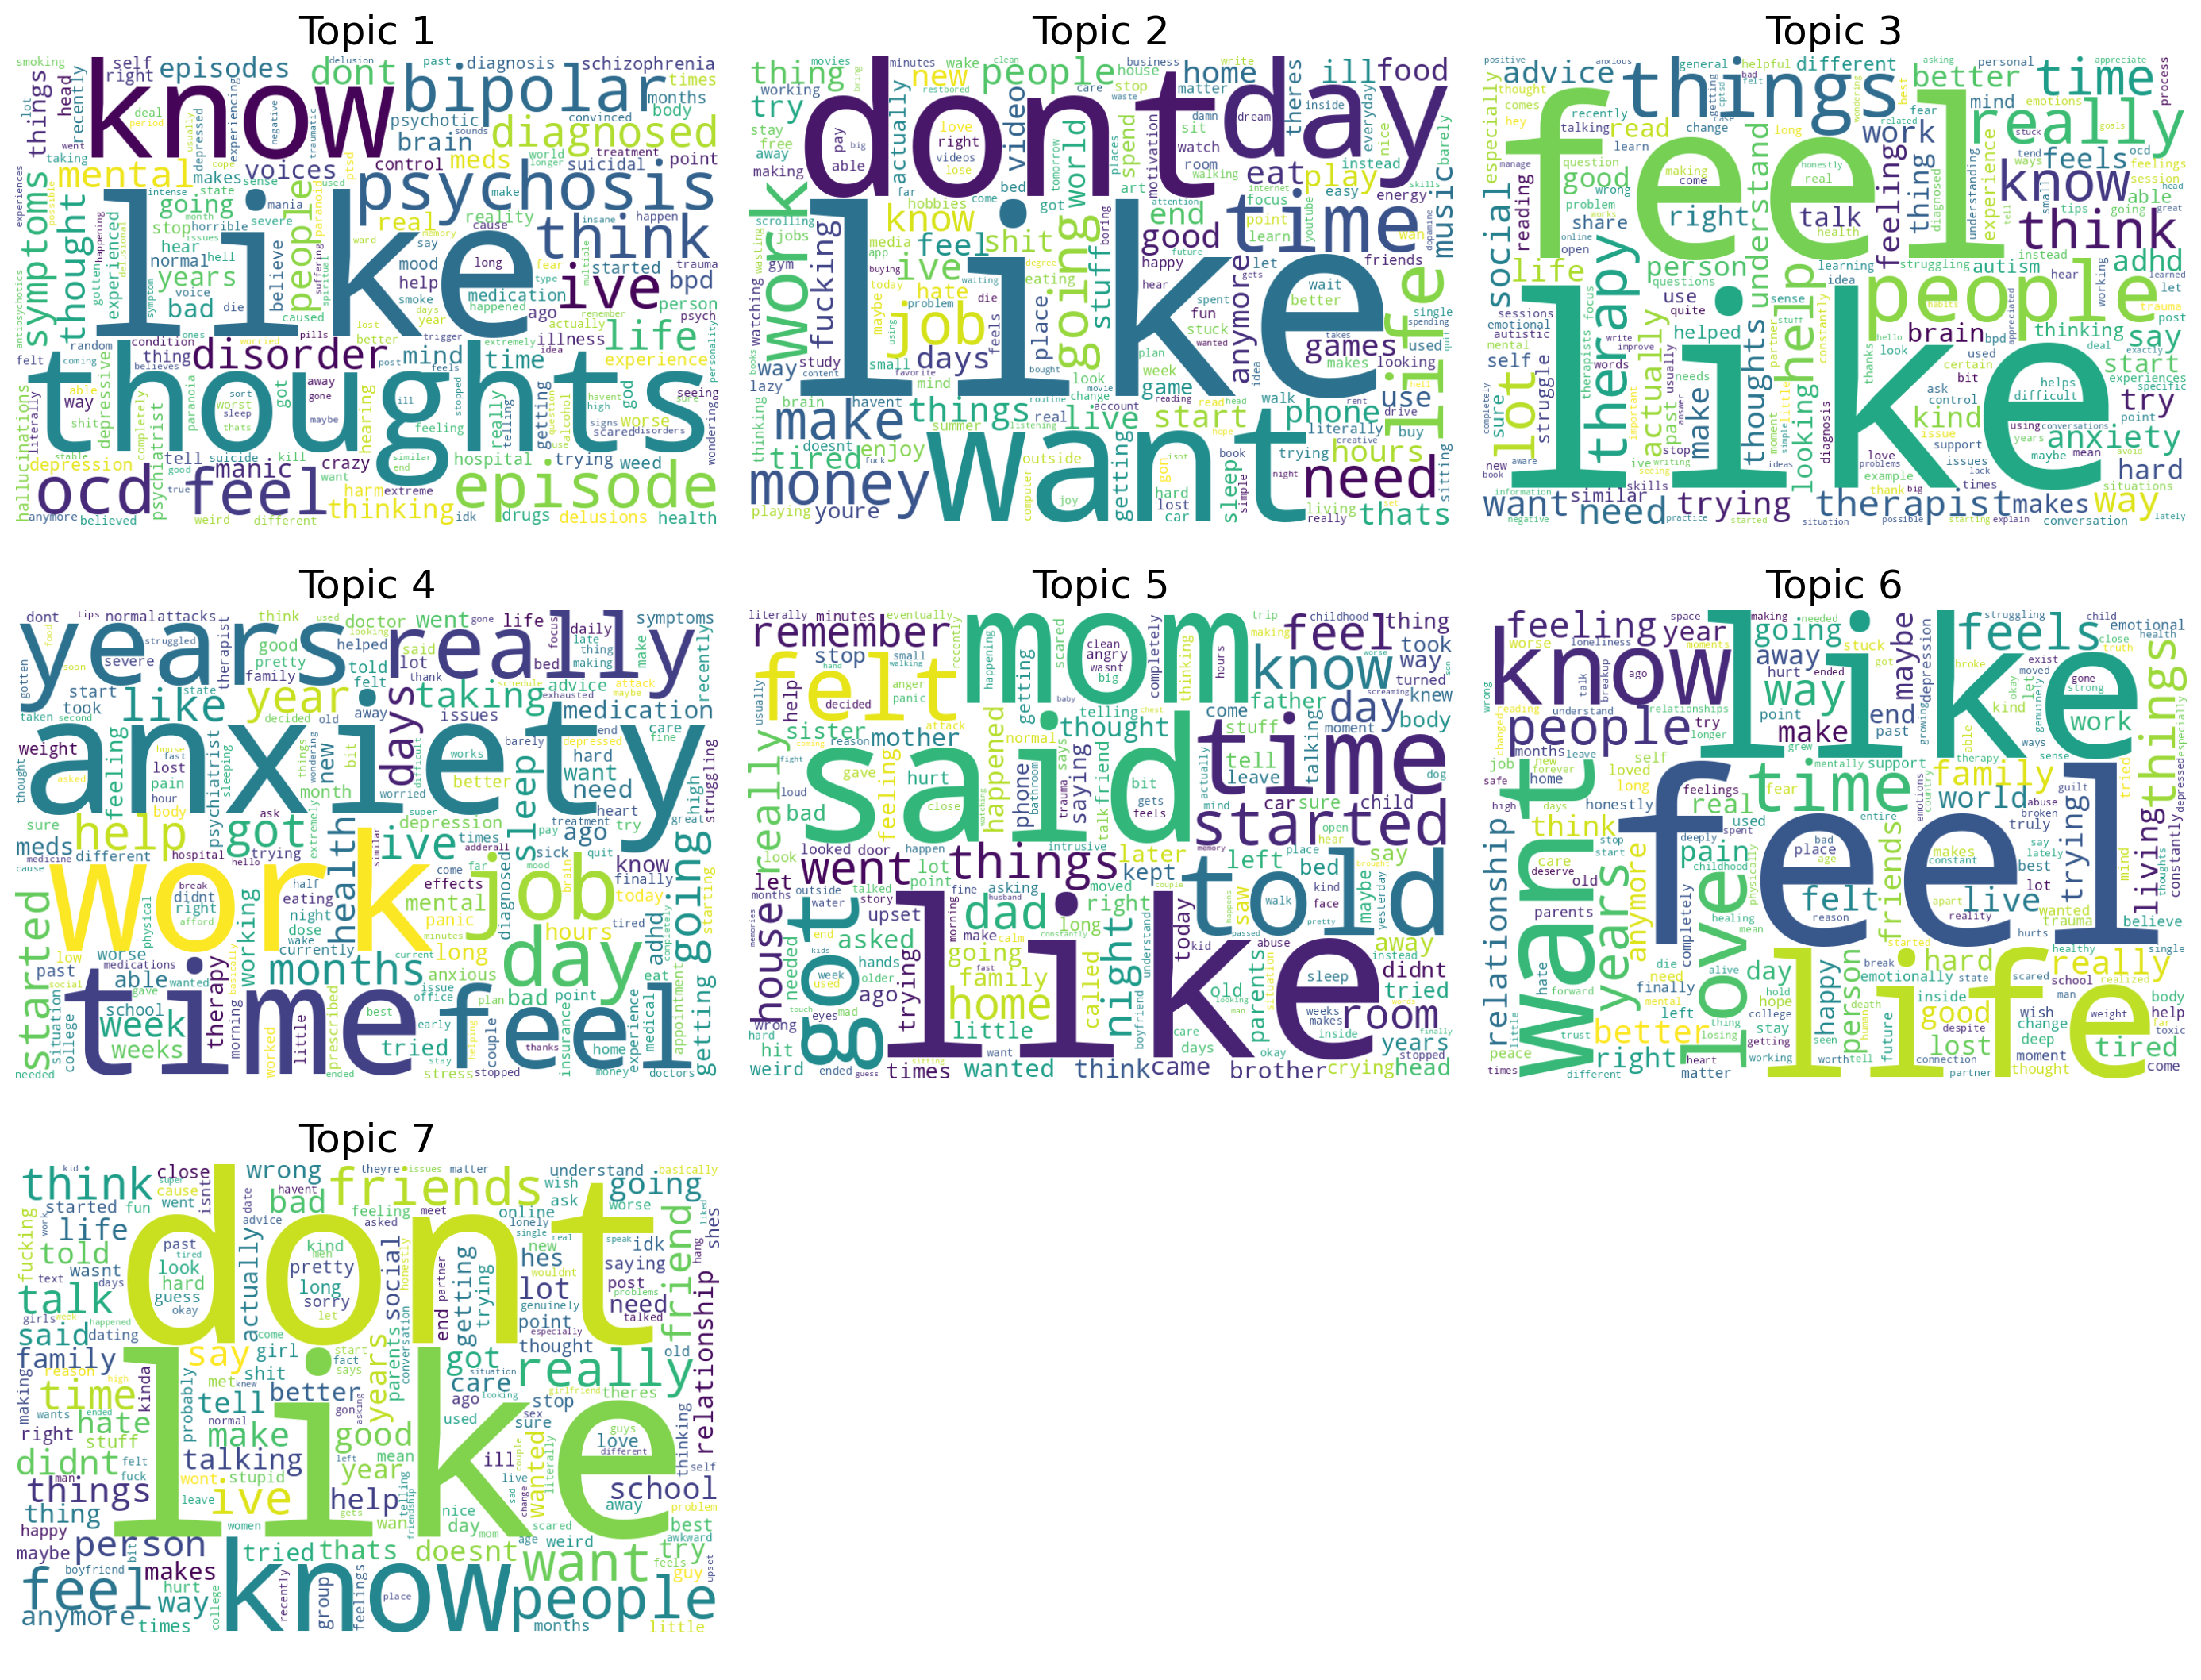

In [ ]:
from wordcloud import WordCloud

n_topics = lda_final.components_.shape[0]
terms = np.array(vectorizer.get_feature_names_out())

cols = 3 if n_topics >= 3 else 2
rows = int(np.ceil(n_topics / cols))

fig, axes = plt.subplots(rows, cols, figsize=(5.2*cols, 4*rows))
axes = np.array(axes).reshape(rows, cols)

for t in range(n_topics):
    freqs = {terms[i]: float(lda_final.components_[t][i]) for i in lda_final.components_[t].argsort()[-400:]}
    r, c = divmod(t, cols)
    wc = WordCloud(width=900, height=600, background_color="white").generate_from_frequencies(freqs)
    axes[r, c].imshow(wc, interpolation="bilinear")
    axes[r, c].set_title(f"Topic {t+1}")
    axes[r, c].axis("off")

for k in range(n_topics, rows*cols):
    r, c = divmod(k, cols)
    axes[r, c].axis("off")

plt.tight_layout()
plt.show()


In [ ]:
%pip install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 539.2/539.2 kB 12.5 MB/s eta 0:00:00


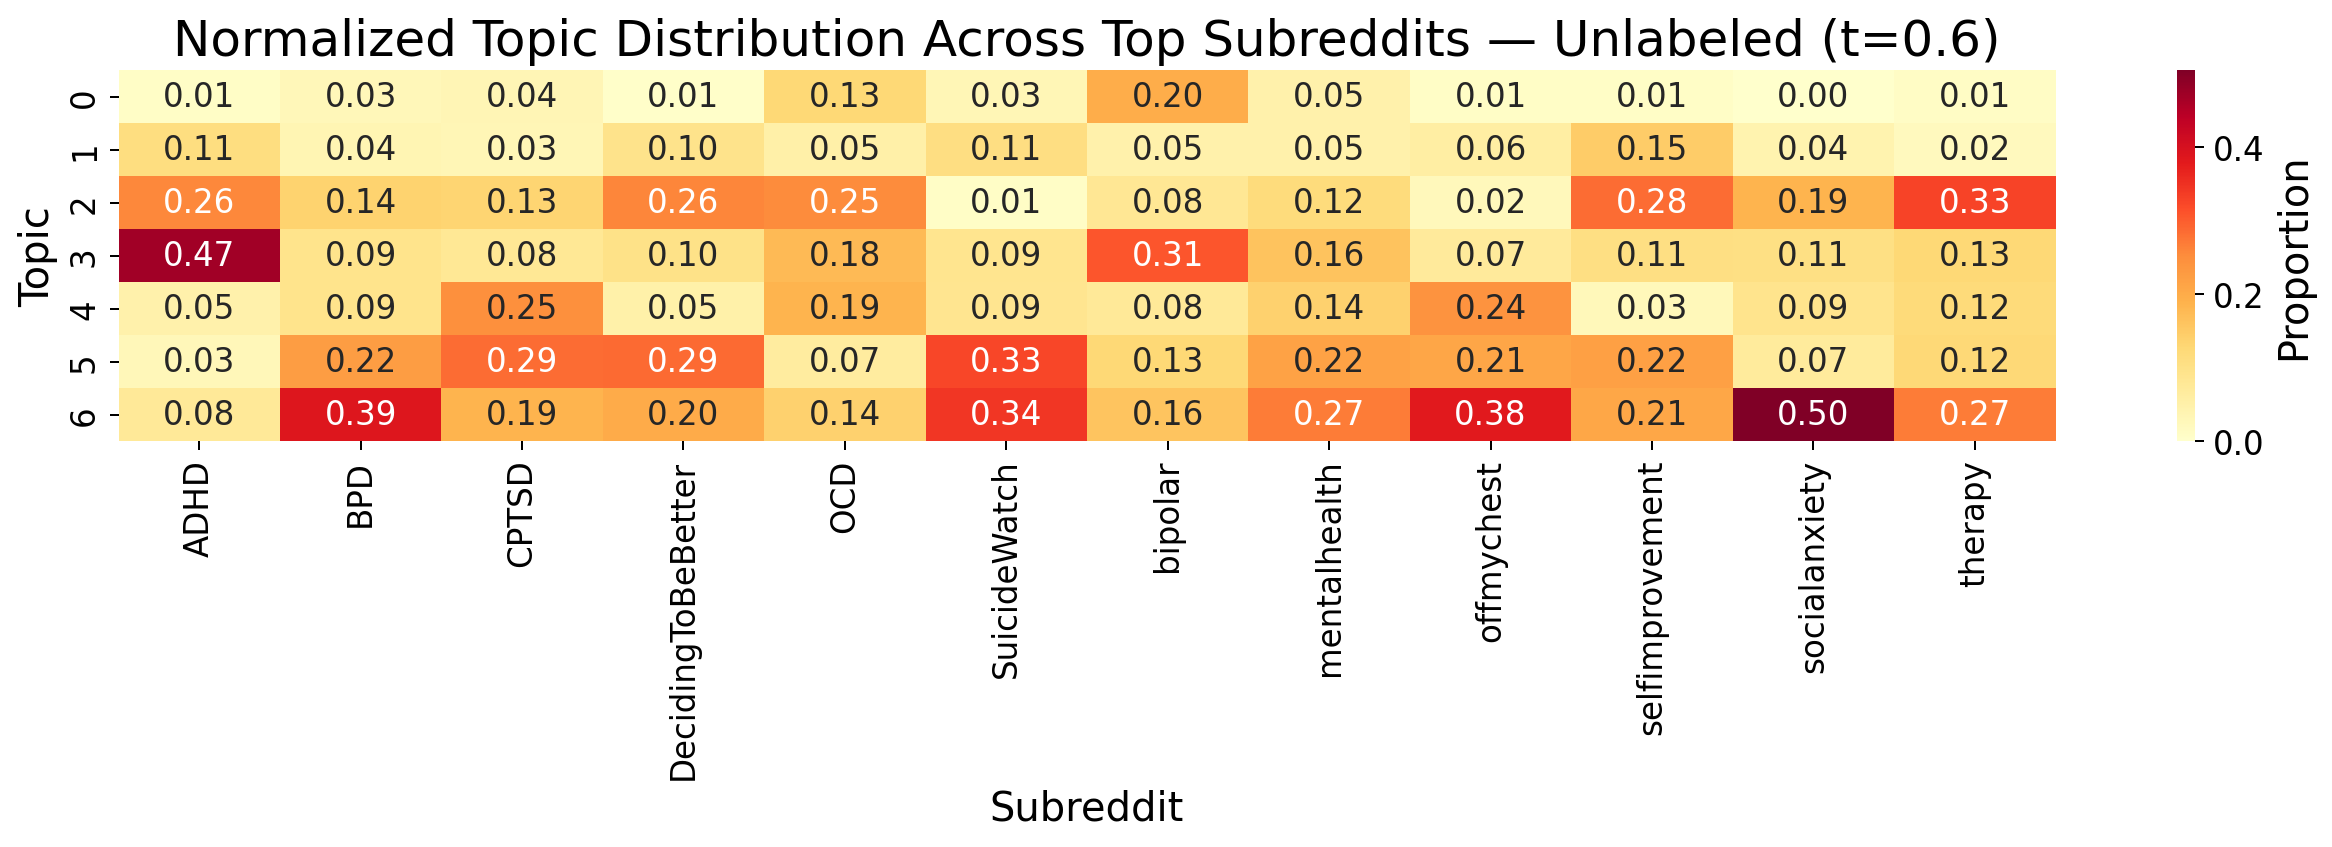

In [ ]:
import seaborn as sns

top_subs = df_unlab["subreddit"].value_counts().head(12).index
df_temp = df_unlab[df_unlab["subreddit"].isin(top_subs)]

pivot = (
    df_temp.groupby(["dominant_topic", "subreddit"])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

pivot_norm = pivot / pivot.sum(axis=0)

plt.figure(figsize=(1.2*pivot.shape[1], 0.7*pivot.shape[0]))
sns.heatmap(pivot_norm, cmap="YlOrRd", annot=True, fmt=".2f", cbar_kws={'label': 'Proportion'})
plt.title("Normalized Topic Distribution Across Top Subreddits — Unlabeled (t=0.6)")
plt.xlabel("Subreddit")
plt.ylabel("Topic")
plt.tight_layout()
plt.show()


✅ Unlabeled posts: 11,695
Vocab size: 6,632
🧩 Topic 1: like, thoughts, know, psychosis, ocd, bipolar, episode, feel, ive, think
🧩 Topic 2: like, dont, want, day, time, work, life, money, job, need
🧩 Topic 3: like, feel, people, things, really, know, therapy, think, lot, help
🧩 Topic 4: anxiety, work, time, years, feel, really, job, day, help, got
🧩 Topic 5: like, said, mom, told, time, got, felt, started, know, things
🧩 Topic 6: feel, like, life, want, know, love, time, people, years, feels
🧩 Topic 7: like, dont, know, people, feel, want, friends, really, ive, think

=== Topic → Emotional Cues ===
   Topic   Valence   Arousal  Dominance  Coverage                 Label
0      1  0.101597 -0.018066   0.013956  0.211223  Low Arousal Positive
1      2  0.301675 -0.053424   0.034371  0.193774  Low Arousal Positive
2      3  0.278054 -0.151730   0.073293  0.189305  Low Arousal Positive
3      4  0.207030 -0.007605   0.003081  0.154677  Low Arousal Positive
4      5  0.362488 -0.175477   0.06

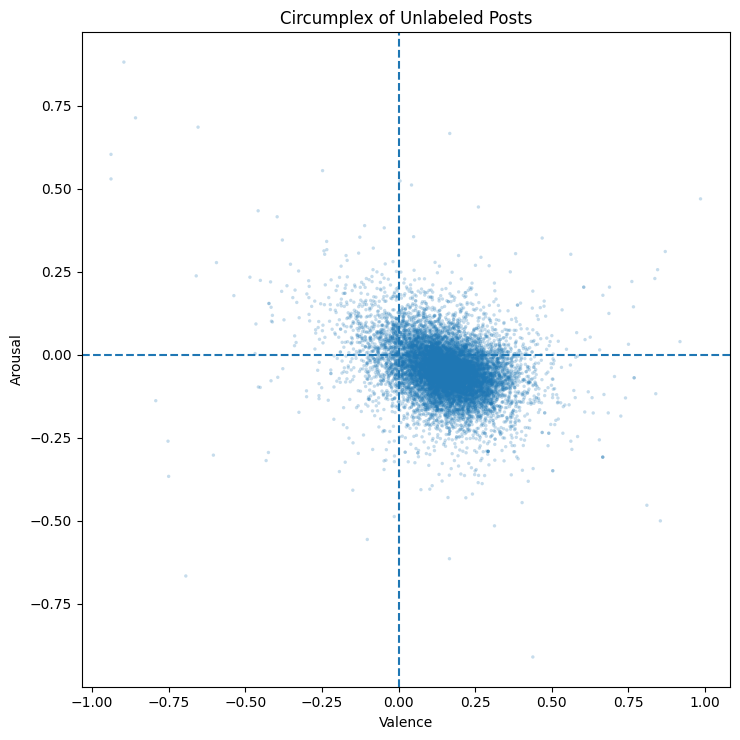


Topic Centers:
   dominant_topic  TopicValence  TopicArousal
0               1      0.076414     -0.013998
1               2      0.178721     -0.063303
2               3      0.195440     -0.067875
3               4      0.122113     -0.036392
4               5      0.137293     -0.057561
5               6      0.168989     -0.031989
6               7      0.156366     -0.042137

✅ Saved → unlabeled_posts_with_topics_and_VAD.csv


In [ ]:
# ============================================
# LDA on unlabeled posts + Topic V/A/D + Post-level Circumplex + CSV Export
# ============================================

import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from scipy.sparse import csr_matrix

# -----------------------
# 0) Config
# -----------------------
DF_PATH       = "reddit_goemo28_probs-augmented-with-VAD.csv"
LEXICON_PATH  = "NRC-VAD-Lexicon-v2.1.txt"
CLEAN_COL     = "processed_selftext"
OPTIMAL_K     = 7
MIN_DF        = 10
MAX_DF        = 0.90

# -----------------------
# 1) Load data (UNLABELED only)
# -----------------------
df = pd.read_csv(DF_PATH, low_memory=False)
assert "num_labels_t0_6" in df.columns, "Missing 'num_labels_t0_6'!"
assert CLEAN_COL in df.columns, f"Missing '{CLEAN_COL}'!"

df_unlab = df[df["num_labels_t0_6"] == 0].copy()
docs = df_unlab[CLEAN_COL].fillna("").astype(str).tolist()
print(f"✅ Unlabeled posts: {len(df_unlab):,}")

# -----------------------
# 2) Vectorize (BoW)
# -----------------------
vectorizer = CountVectorizer(max_df=MAX_DF, min_df=MIN_DF, stop_words="english")
X = vectorizer.fit_transform(docs)
terms = np.array(vectorizer.get_feature_names_out())
print(f"Vocab size: {len(terms):,}")

# -----------------------
# 3) LDA (k = 7)
# -----------------------
lda_final = LatentDirichletAllocation(
    n_components=OPTIMAL_K, random_state=42, max_iter=30, learning_method="batch"
)
lda_final.fit(X)

for i, topic_vec in enumerate(lda_final.components_):
    top_ids = np.argsort(topic_vec)[-10:][::-1]
    print(f"🧩 Topic {i+1}: {', '.join(terms[top_ids])}")

topic_probs = lda_final.transform(X)
df_unlab["dominant_topic"] = topic_probs.argmax(axis=1) + 1
df_unlab["topic_confidence"] = topic_probs.max(axis=1)

# -----------------------
# 4) Load NRC-VAD lexicon
# -----------------------
def norm(s):
    return re.sub(r"\s+", " ", str(s).strip().lower())

vad = pd.read_csv(LEXICON_PATH, sep="\t", header=0,
                  names=["term","valence","arousal","dominance"])
vad["key"] = vad["term"].apply(norm)
vad_map = vad.set_index("key")[["valence","arousal","dominance"]].to_dict(orient="index")

# -----------------------
# 5) Topic → V/A/D Profiles
# -----------------------
def topic_word_probs(lda_model):
    comp = lda_model.components_.astype(float)
    return comp / comp.sum(axis=1, keepdims=True)

tw = topic_word_probs(lda_final)

def topic_emotion_profile(topic_idx, terms, tw_probs, topn=30, pos_thr=0.0, ar_thr=0.0):
    probs = tw_probs[topic_idx]
    top_ids = np.argsort(probs)[-topn:][::-1]
    rows, covered = [], 0.0
    for t, w in zip(terms[top_ids], probs[top_ids]):
        k = norm(t)
        if k in vad_map:
            v,a,d = vad_map[k]["valence"], vad_map[k]["arousal"], vad_map[k]["dominance"]
            rows.append((t, w, v, a, d))
            covered += w
    drivers = pd.DataFrame(rows, columns=["term","weight","valence","arousal","dominance"])
    if drivers.empty:
        return {"Topic": topic_idx+1, "Valence": np.nan, "Arousal": np.nan, "Dominance": np.nan, "Coverage": 0, "Label": "Insufficient"}

    w = drivers["weight"].values
    V = np.sum(drivers["valence"].values * w) / np.sum(w)
    A = np.sum(drivers["arousal"].values * w) / np.sum(w)
    D = np.sum(drivers["dominance"].values * w) / np.sum(w)

    vlabel = "Positive" if V > pos_thr else "Negative"
    alabel = "High Arousal" if A > ar_thr else "Low Arousal"
    return {"Topic": topic_idx+1, "Valence": V, "Arousal": A, "Dominance": D, "Coverage": covered, "Label": f"{alabel} {vlabel}"}

profiles = [topic_emotion_profile(i, terms, tw) for i in range(OPTIMAL_K)]
summary_df = pd.DataFrame(profiles)
print("\n=== Topic → Emotional Cues ===")
print(summary_df)

# -----------------------
# 6) Post-level V/A scoring
# -----------------------
vocab_keys = [norm(t) for t in terms]
val_vec = np.array([vad_map[k]["valence"] if k in vad_map else np.nan for k in vocab_keys])
aro_vec = np.array([vad_map[k]["arousal"] if k in vad_map else np.nan for k in vocab_keys])

X_csr = csr_matrix(X)
valence_per_post = np.full(len(df_unlab), np.nan)
arousal_per_post = np.full(len(df_unlab), np.nan)

for i in range(len(df_unlab)):
    s,e = X_csr.indptr[i], X_csr.indptr[i+1]
    idxs = X_csr.indices[s:e]
    cnts = X_csr.data[s:e].astype(float)
    mask = (~np.isnan(val_vec[idxs])) & (~np.isnan(aro_vec[idxs]))
    if np.any(mask):
        V,A = val_vec[idxs][mask], aro_vec[idxs][mask]
        wsum = cnts[mask].sum()
        valence_per_post[i] = (V*cnts[mask]).sum()/wsum
        arousal_per_post[i] = (A*cnts[mask]).sum()/wsum

df_unlab["valence_vad"] = valence_per_post
df_unlab["arousal_vad"] = arousal_per_post

# -----------------------
# 7) Circumplex Plot (inline)
# -----------------------
mask = ~(df_unlab["valence_vad"].isna() | df_unlab["arousal_vad"].isna())

plt.figure(figsize=(7.5, 7.5))
plt.scatter(df_unlab.loc[mask,"valence_vad"], df_unlab.loc[mask,"arousal_vad"],
            s=6, alpha=0.25, edgecolors="none")
plt.axvline(0, ls="--"); plt.axhline(0, ls="--")
plt.xlabel("Valence"); plt.ylabel("Arousal")
plt.title("Circumplex of Unlabeled Posts")
plt.tight_layout()
plt.show()

# -----------------------
# 8) Topic centers on Circumplex
# -----------------------
topic_centers = (df_unlab.loc[mask]
                 .groupby("dominant_topic")[["valence_vad","arousal_vad"]]
                 .mean()
                 .reset_index()
                 .rename(columns={"valence_vad":"TopicValence","arousal_vad":"TopicArousal"}))
print("\nTopic Centers:")
print(topic_centers)

# -----------------------
# 9) Export CSV (for citation examples & qualitative interpretation)
# -----------------------
OUT_FULL_CSV = "unlabeled_posts_with_topics_and_VAD.csv"

extra_cols = [c for c in ["id","post_id","title","subreddit","created_utc","url"] if c in df_unlab.columns]

df_unlab[[CLEAN_COL, "dominant_topic","topic_confidence","valence_vad","arousal_vad"] + extra_cols] \
    .to_csv(OUT_FULL_CSV, index=False)

print(f"\n✅ Saved → {OUT_FULL_CSV}")


In [ ]:
import pandas as pd

# Load your file
path = "unlabeled_posts_with_topics_and_VAD.csv"
df = pd.read_csv(path)

# Filter by id
post = df[df["id"].astype(str).str.lower() == "1m5twi6"]

# Display results
if not post.empty:
    print(post[["dominant_topic","valence_vad","arousal_vad","subreddit","url"]])
else:
    print("No post found with id = '1m5twi6'")



    dominant_topic  valence_vad  arousal_vad   subreddit  \
38               7     0.215505    -0.043371  depression   

                                                  url  
38  https://www.reddit.com/r/depression/comments/1...  


In [ ]:
import nbformat
import os

# 1) Use the current notebook filename
# In Colab, this is a bit tricky, so we’ll just make a clean *copy*.

original_nb = "original.ipynb"   # <-- change this to your downloaded filename if needed
cleaned_nb  = "cleaned_for_github.ipynb"

# If you're running *inside* Colab without the file yet,
# first do: File → Download → then upload back to Colab sidebar
# and set original_nb to that name.

nb = nbformat.read(original_nb, as_version=4)

# 2) Remove widget metadata if present
if "widgets" in nb.metadata:
    print("Found 'widgets' metadata, removing it…")
    del nb.metadata["widgets"]
else:
    print("No 'widgets' metadata found in notebook metadata.")

# 3) Save to a new notebook file
nbformat.write(nb, cleaned_nb)
print(f"✅ Saved cleaned notebook as: {cleaned_nb}")
